# **Model**

Ce notebook se focalise sur la recherche du *meilleur* mod√®le √† retenir pour la mise en production.

La premi√®re partie "Pr√©paration de la mod√©lisation" passe en revue les √©tapes de traitement, en expliquant leur finalit√©, et en justifiant les choix effectu√©s parmi les options disponibles. Ces choix sont effectu√©s en relation avec les sp√©cificit√©s du jeu de donn√©es Home Credit et avec le but pr√©dictif (ici de la classification binaire supervis√©e avec classes d√©s√©quilibr√©es). Par choix, nous entendons celui des strat√©gies (et leurs impl√©mentations) retenues et celui de leurs param√®tres fix√©s ou restreints √† un sous-domaine √† explorer lors du benchmark.

La seconde "Evaluation des mod√®les" se concentre sur la mise en place du *framework* sur la base duquel nous allons effectuer notre recherche en grille, c'est-√†-dire un benchmark de mod√®les dont on fait varier les hyperparam√®tres dans les domaines retenus dans la premi√®re partie. De ce poin de vue, la premi√®re partie est bien une sp√©cification fonctionnelle de la seconde qui en est la r√©alisation. L'ensemble de ces √©tapes p√©paratoires qui interviennent en amont de l'entra√Ænement d'un mod√®le; l'entra√Ænement du mod√®le et l'√©valuation des performance du mod√®les, sont int√©gr√©es dans une fonction principale `home_credit.best_model_search.kfold_eval_model` qui joue le r√¥le de *pipeline*.

La derni√®re partie "Benchmark des mod√®les" √©value et compare les multiples configurations envisag√©es en vue de d√©terminer la plus performante d'entre-elles. L'enjeu est ici de bien d√©finir, objectivement, ce que l'on entend par performance. La performance objective a de nombreuses facettes, parfois contradictoires (corr√©l√©es n√©gativement). En gagnant d'un c√¥t√©, on peut perdre de l'autre. Mais pour simplifier, on distingura principalement les performances m√©tier, synth√©tis√©e dans une fonction de co√ªt objective qu'il s'agit de minimiser (on pourra ici entendre co√ªt pour l'entreprise), et les performances techniques qui se d√©clinent spatialement (la quantit√© de ressources mobilis√©es, notamment la m√©moire) et temporellement (la v√©locit√© de l'ex√©cution).

# Pr√©paration de la mod√©lisation

## Chargement des donn√©es pr√©-trait√©es

In [2]:
from home_credit.load import load_prep_dataset
data = load_prep_dataset("baseline_v1")
display(data)

SK_ID_CURR  TARGET  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT   
0           100002       1             0          202500.0    406597.5  \
1           100003       0             0          270000.0   1293502.5   
2           100004       0             0           67500.0    135000.0   
3           100006       0             0          135000.0    312682.5   
4           100007       0             0          121500.0    513000.0   
...            ...     ...           ...               ...         ...   
356250      456221      -1             0          121500.0    412560.0   
356251      456222      -1             2          157500.0    622413.0   
356252      456223      -1             1          202500.0    315000.0   
356253      456224      -1             0          225000.0    450000.0   
356254      456250      -1             0          135000.0    312768.0   

        AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH   
0           24700.5         351000.0                    0.018801       -9461  \
1           35698.5        1129500.0                    0.003541      -16765   
2            6750.0         135000.0                    0.010032      -19046   
3           29686.5         297000.0                    0.008019      -19005   
4           21865.5         513000.0                    0.028663      -19932   
...             ...              ...                         ...         ...   
356250      17473.5         270000.0                    0.002042      -19970   
356251      31909.5         495000.0                    0.035792      -11186   
356252      33205.5         315000.0                    0.026392      -15922   
356253      25128.0         450000.0                    0.018850      -13968   
356254      24709.5         270000.0                    0.006629      -13962   

        DAYS_EMPLOYED  ...  CC_NAME_CONTRACT_STATUS_Sent_proposal_MIN_nan   
0                -637  ...                                           True  \
1               -1188  ...                                           True   
2                -225  ...                                           True   
3               -3039  ...                                          False   
4               -3038  ...                                           True   
...               ...  ...                                            ...   
356250          -5169  ...                                           True   
356251          -1149  ...                                           True   
356252          -3037  ...                                           True   
356253          -2731  ...                                           True   
356254           -633  ...                                          False   

        CC_NAME_CONTRACT_STATUS_Sent_proposal_MAX_False   
0                                                 False  \
1                                                 False   
2                                                 False   
3                                                  True   
4                                                 False   
...                                                 ...   
356250                                            False   
356251                                            False   
356252                                            False   
356253                                            False   
356254                                             True   

        CC_NAME_CONTRACT_STATUS_Sent_proposal_MAX_True   
0                                                False  \
1                                                False   
2                                                False   
3                                                False   
4                                                False   
...                                                ...   
356250                                           False   
356251                                           False   
35

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356255 entries, 0 to 356254
Columns: 790 entries, SK_ID_CURR to CC_NAME_CONTRACT_STATUS_Signed_MAX_nan
dtypes: bool(169), float64(580), int64(41)
memory usage: 1.7 GB


SK_ID_CURR         TARGET   CNT_CHILDREN  AMT_INCOME_TOTAL   
count  356255.000000  356255.000000  356255.000000      3.562550e+05  \
mean   278128.000000      -0.067140       0.414316      1.701161e+05   
std    102842.104413       0.449443       0.720378      2.235068e+05   
min    100001.000000      -1.000000       0.000000      2.565000e+04   
25%    189064.500000       0.000000       0.000000      1.125000e+05   
50%    278128.000000       0.000000       0.000000      1.530000e+05   
75%    367191.500000       0.000000       1.000000      2.025000e+05   
max    456255.000000       1.000000      20.000000      1.170000e+08   

         AMT_CREDIT    AMT_ANNUITY  AMT_GOODS_PRICE   
count  3.562550e+05  356219.000000     3.559770e+05  \
mean   5.877674e+05   27425.560657     5.280200e+05   
std    3.986237e+05   14732.808190     3.660650e+05   
min    4.500000e+04    1615.500000     4.050000e+04   
25%    2.700000e+05   16731.000000     2.340000e+05   
50%    5.002110e+05   25078.500000     4.500000e+05   
75%    7.975575e+05   34960.500000     6.750000e+05   
max    4.050000e+06  258025.500000     4.050000e+06   

       REGION_POPULATION_RELATIVE     DAYS_BIRTH  DAYS_EMPLOYED  ...   
count               356255.000000  356255.000000  356255.000000  ...  \
mean                     0.020917  -16041.248841   64317.231413  ...   
std                      0.013915    4358.803980  141705.532576  ...   
min                      0.000253  -25229.000000  -17912.000000  ...   
25%                      0.010006  -19676.000000   -2781.000000  ...   
50%                      0.018850  -15755.000000   -1224.000000  ...   
75%                      0.028663  -12425.000000    -290.000000  ...   
max                      0.072508   -7338.000000  365243.000000  ...   

       INSTAL_AMT_INSTALMENT_MEAN  INSTAL_AMT_INSTALMENT_SUM   
count                3.395870e+05               3.395870e+05  \
mean                 1.861577e+04               6.831369e+05   
std                  2.346509e+04               8.933805e+05   
min                  0.000000e+00               0.000000e+00   
25%                  7.897470e+03               1.366834e+05   
50%                  1.272616e+04               3.343952e+05   
75%                  2.164516e+04               8.577727e+05   
max                  2.504590e+06               3.247978e+07   

       INSTAL_AMT_PAYMENT_MIN  INSTAL_AMT_PAYMENT_MAX   
count            3.395780e+05            3.395780e+05  \
mean             5.282753e+03            1.400438e+05   
std              1.449867e+04            2.496554e+05   
min              0.000000e+00            2.250000e-01   
25%              4.153500e+01            1.439653e+04   
50%              2.323575e+03            3.703561e+04   
75%              7.158724e+03            1.350000e+05   
max              2.504590e+06            3.771488e+06   

       INSTAL_AMT_PAYMENT_MEAN  INSTAL_AMT_PAYMENT_SUM   
count             3.395780e+05            3.395870e+05  \
mean              1.900381e+04            6.904942e+05   
std               2.523135e+04            9.308977e+05   
min               1.890000e-01            0.000000e+00   
25%               7.582365e+03            1.332007e+05   
50%               1.240398e+04            3.248035e+05   
75%               2.164505e+04            8.497309e+05   
max               2.504590e+06            3.268928e+07   

       INSTAL_DAYS_ENTRY_PAYMENT_MAX  INSTAL_DAYS_ENTRY_PAYMENT_MEAN   
count                  339578.000000                   339578.000000  \
mean                     -328.433435                     -922.095504   
std                       537.367821                      597.181989   
min                     -3071.000000                    -3071.000000   
25%                      -387.000000                    -1312.043107   
50%                       -65.000000                     -806.576364   
75%                       -26.000000                     -433.857143   
max                       

n     n_u  n_na  Filling rate   
SK_ID_CURR                          356255  356255     0           1.0  \
TARGET                              356255       3     0           1.0   
CNT_CHILDREN                        356255      16     0           1.0   
AMT_INCOME_TOTAL                    356255    2741     0           1.0   
AMT_CREDIT                          356255    6480     0           1.0   
...                                    ...     ...   ...           ...   
OCCUPATION_TYPE_IT_staff            356255       2     0           1.0   
OCCUPATION_TYPE_Laborers            356255       2     0           1.0   
OCCUPATION_TYPE_Low_skill_Laborers  356255       2     0           1.0   
OCCUPATION_TYPE_Managers            356255       2     0           1.0   
OCCUPATION_TYPE_Medicine_staff      356255       2     0           1.0   

                                    Shannon entropy   dtypes  
SK_ID_CURR                                 1.000000    int64  
TARGET                                     0.000008    int64  
CNT_CHILDREN                               0.000045    int64  
AMT_INCOME_TOTAL                           0.007694  float64  
AMT_CREDIT                                 0.018189  float64  
...                                             ...      ...  
OCCUPATION_TYPE_IT_staff                   0.000006     bool  
OCCUPATION_TYPE_Laborers                   0.000006     bool  
OCCUPATION_TYPE_Low_skill_Laborers         0.000006     bool  
OCCUPATION_TYPE_Managers                   0.000006     bool  
OCCUPATION_TYPE_Medicine_staff             0.000006     bool  

[150 rows x 6 columns]

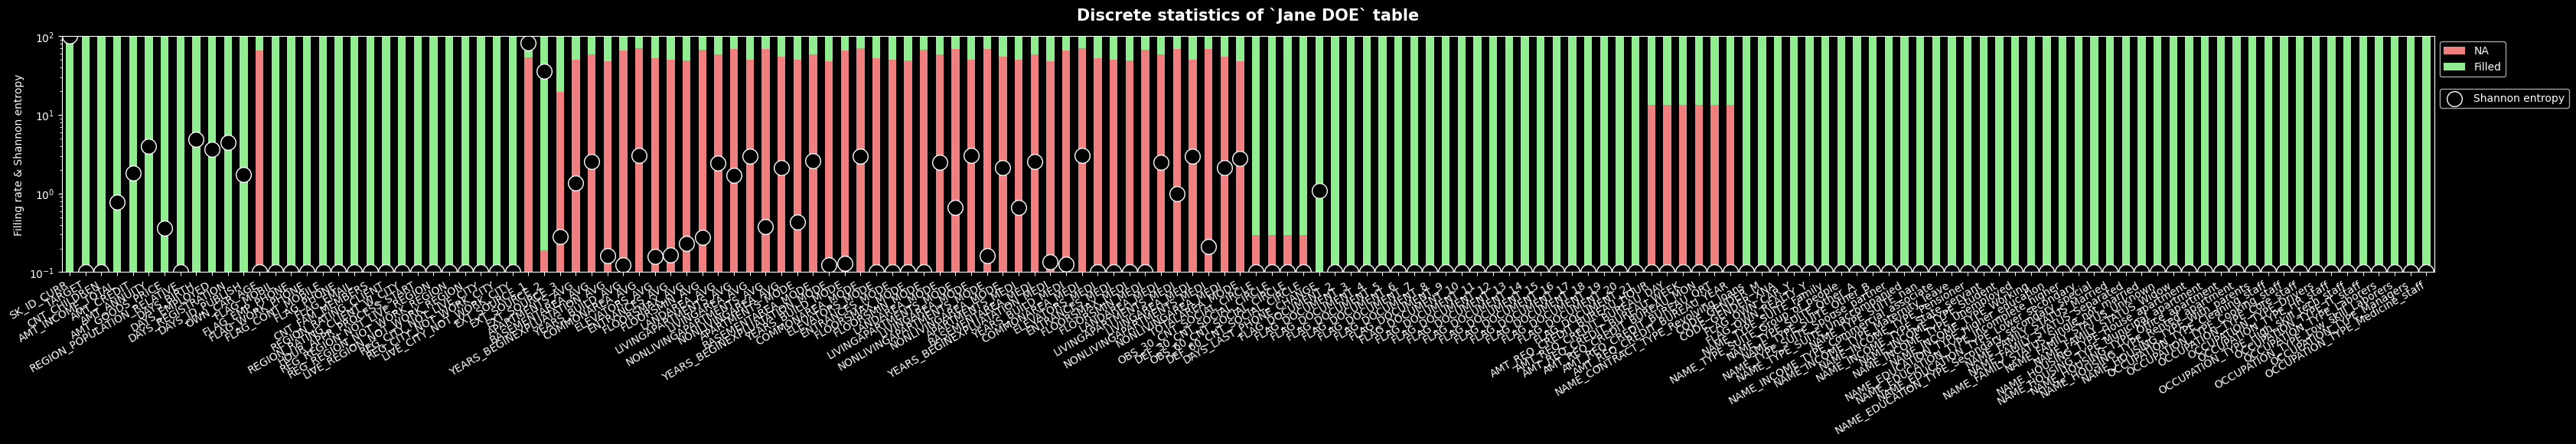

In [ ]:
from pepper.utils import show_discrete_stats
data.info()
display(data.describe())
show_discrete_stats(data[data.columns[:150]], ratio=5)

## Imputation des valeurs manquantes

Hormis quelques exception, les mod√®les n'aiment pas les valeurs manquantes.

Pour pouvoir passer de la phase d'ing√©nierie des donn√©es √† celle de mod√©lisation, il faut s'√™tre d'bord assur√©s de n'avoir plus de NA. Cela devrait avoir √©t√© trait√© dans le cadre de cette ing√©nierie, mais il peut rester des reliquats, et pour bien gagder l'entr√©e de cette phase de mod√©lisation, il est utile de commencer par une passe de v√©rification (`assert`) et l'application d'une strat√©gie d'imputation par d√©faut pour les reliquats de valeurs manquantes.

Par exemple, m√™me si LightGBM accepte des NA, un simple sampling `imblearn`, indispensable dans notre situation de d√©s√©quilibre de classes, √©chouera s'il devait rester des NA :

```
ValueError: Input X contains NaN.

SMOTETomek does not accept missing values encoded as NaN natively.

For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively.

Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values.

See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values
```

Scikit-Learn propose un module `impute` qui propose plusieurs strat√©gies d'imputations.

Voir la section [**Imputation des valeurs manquantes** (6.4)](https://scikit-learn.org/stable/modules/impute.html) du manuel d'utilisation.

In [28]:
from home_credit.load import load_prep_dataset
from home_credit.best_model_search import default_imputation

data = load_prep_dataset("baseline_v1")
data = data.sample(10_000)

print("NA or INF before imput:", (data.isna() | np.isinf(data)).any().any())

# Cannot be done inplace
data = default_imputation(data)
data_train = data[data.TARGET > -1]
data_test = data[data.TARGET == -1]

print("NA or INF after imput:", (data.isna() | np.isinf(data)).any().any())

display(data)

NA or INF before imput: True
NA or INF after imput: False


SK_ID_CURR  TARGET  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT   
34625     140123.0     0.0           1.0          171000.0   1506816.0  \
131054    252004.0     0.0           0.0          112500.0    808650.0   
53334     161770.0     0.0           1.0          135000.0    354276.0   
251289    390765.0     0.0           0.0          135000.0    640080.0   
278743    422924.0     0.0           0.0          135000.0   1211049.0   
...            ...     ...           ...               ...         ...   
100930    217190.0     0.0           0.0          112500.0    241618.5   
236858    374350.0     0.0           2.0          171000.0    533304.0   
56810     165835.0     0.0           2.0          184500.0   1206000.0   
178527    306875.0     0.0           0.0          405000.0    545040.0   
123076    242718.0     0.0           0.0          135000.0    225000.0   

        AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH   
34625       49927.5        1350000.0                    0.009630    -13698.0  \
131054      23773.5         675000.0                    0.007120    -22542.0   
53334       22770.0         292500.0                    0.006305    -12943.0   
251289      31261.5         450000.0                    0.009657    -20692.0   
278743      35541.0        1057500.0                    0.006671    -16617.0   
...             ...              ...                         ...         ...   
100930      23665.5         229500.0                    0.010006    -20932.0   
236858      25785.0         405000.0                    0.006207    -11610.0   
56810       46066.5        1206000.0                    0.010006    -14927.0   
178527      26509.5         450000.0                    0.005313    -10514.0   
123076      11250.0         225000.0                    0.008625    -17005.0   

        DAYS_EMPLOYED  ...  CC_NAME_CONTRACT_STATUS_Sent_proposal_MIN_nan   
34625         -2998.0  ...                                            1.0  \
131054       365243.0  ...                                            0.0   
53334         -3223.0  ...                                            0.0   
251289        -1119.0  ...                                            1.0   
278743        -2373.0  ...                                            1.0   
...               ...  ...                                            ...   
100930        -1341.0  ...                                            0.0   
236858        -1982.0  ...                                            0.0   
56810          -139.0  ...                                            1.0   
178527        -2025.0  ...                                            1.0   
123076         -923.0  ...                                            1.0   

        CC_NAME_CONTRACT_STATUS_Sent_proposal_MAX_False   
34625                                               0.0  \
131054                                              1.0   
53334                                               1.0   
251289                                              0.0   
278743                                              0.0   
...                                                 ...   
100930                                              1.0   
236858                                              1.0   
56810                                               0.0   
178527                                              0.0   
123076                                              0.0   

        CC_NAME_CONTRACT_STATUS_Sent_proposal_MAX_True   
34625                                              0.0  \
131054                                             0.0   
53334                                              0.0   
251289                                             0.0   
278743                                             0.0   
...                                                ...   
100930                                             0.0   
236858                                             0.0   
56

## R√©duction de dimentionnalit√©

Le jeu de donn√©es pr√©par√©e `baseline_v1` contient 790 caract√©ristiques.

<mark>...freestyle</mark>

Une r√©duction de dimensionnalit√© (et par induction, de sparsit√©) peut am√©liorer les performances techniques du mod√®le (espace m√©moire, temps d'ex√©cution) mais √©galement la performance m√©tier en r√©duisant le risque de sur-apprentissage (m√©morisation des donn√©es plut√¥t que g√©n√©ralisation).

Voir cet article de Wikipedia √† propos du fl√©au ou mal√©diction de la dimension [**Curse of dimensionality**](https://en.wikipedia.org/wiki/Curse_of_dimensionality)

Avec un jeu de donn√©es d'environ 800 colonnes par 300 000 lignes, il est clair que la r√©duction de dimensionnalit√© peut aider √† acc√©l√©rer l'entra√Ænement du mod√®le et √† am√©liorer les performances.

Une approche de r√©duction de dimensionnalit√© lin√©aire, comme l'analyse en composantes principales (PCA), peut √™tre un bon point de d√©part. PCA permet de transformer les donn√©es en un espace de dimensions r√©duites, en maximisant la variance des donn√©es projet√©es sur ces dimensions r√©duites. Cette approche est simple √† mettre en ≈ìuvre et est bien adapt√©e aux jeux de donn√©es de grande dimension.

Cependant, il peut y avoir des cas o√π la structure sous-jacente des donn√©es n'est pas lin√©aire, et cela semble √™tre le cas notamment pour les 3 sources externes de scoring client qui caracolent en t√™tre des caract√©ristiques importantes (les facteurs les plus d√©terminants de la pr√©diction). Il est donc tr√®s probable qu'une approche non lin√©aire telle que t-SNE (t-Distributed Stochastic Neighbor Embedding) sera plus appropri√©e. t-SNE est capable de pr√©server les relations non lin√©aires entre les donn√©es, mais il peut √™tre plus co√ªteux en temps de calcul que PCA.

Notons que la r√©duction de dimensionnalit√© peut entra√Æner une perte d'information, il conviendra donc d'avaluer son impact sur les performances dans le cadre du benchmark.

**TODO**

## Echantillonnage avec r√©√©quilibrage de classes

Les deux classes cibles sont d√©s√©quilibr√©es : les clients d√©faillants ne repr√©sentent que $8\,\%$ des clients.

Ce sont pourtant ces clients qu'il faut sp√©cialement pourvoir identifier en minimisant les faux n√©gatifs plut√¥t que les faux positifs.

Pour entra√Æner un mod√®le √† reconna√Ætre ces cas de d√©faillance, il convient de lui fournir un √©chantillon r√©-√©quilibr√© (o√π la moiti√© de l'effectif correspond √† ces cas de d√©faillance).

Il existe plusieurs techniques de sous-√©chantillonnage (par exemple le sous √©chantillonnage al√©atoire ou NearMiss), sur-√©chantillonnage (par exemple SMOTE et ses variantes) et combin√©es des deux (par exemple SMOTETomek).

La plupart de ces techniques sont mises en oeuvre par la librairie [**`imblearn`**](https://imbalanced-learn.org/stable/install.html) que nous allons utiliser.

### Exemple de sous-√©chantillonnage

Exemple d'utilisation de [**`RandomUnderSampler`**](https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html) (extrait de la documentation de l'API).

In [ ]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.under_sampling import RandomUnderSampler
X, y = make_classification(
    n_classes=2, class_sep=2,
    weights=[0.1, 0.9], n_informative=3, n_redundant=1, flip_y=0,
    n_features=20, n_clusters_per_class=1, n_samples=1000, random_state=10
)
print('Original dataset shape %s' % Counter(y))

rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_res))

Original dataset shape Counter({1: 900, 0: 100})
Resampled dataset shape Counter({0: 100, 1: 100})


### Exemple de sur-√©chantillonnage

Exemple d'utilisation de [**`SMOTE`**](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html) (extrait de la documentation de l'API).

In [ ]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
X, y = make_classification(n_classes=2, class_sep=2,
weights=[0.1, 0.9], n_informative=3, n_redundant=1, flip_y=0,
n_features=20, n_clusters_per_class=1, n_samples=1000, random_state=10)
print('Original dataset shape %s' % Counter(y))

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_res))

Original dataset shape Counter({1: 900, 0: 100})
Resampled dataset shape Counter({0: 900, 1: 900})


### Exemple hybride

Exemple d'utilisation de [**`SMOTETomek`**](https://imbalanced-learn.org/stable/references/generated/imblearn.combine.SMOTETomek.html) (extrait de la documentation de l'API).

In [ ]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.combine import SMOTETomek
X, y = make_classification(n_classes=2, class_sep=2,
weights=[0.1, 0.9], n_informative=3, n_redundant=1, flip_y=0,
n_features=20, n_clusters_per_class=1, n_samples=1000, random_state=10)
print('Original dataset shape %s' % Counter(y))

smt = SMOTETomek(random_state=42)
X_res, y_res = smt.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_res))

Original dataset shape Counter({1: 900, 0: 100})
Resampled dataset shape Counter({0: 900, 1: 900})


## Partition du jeu de donn√©es

Pas grand chose √† dire √† ce sujet, c'est standard : s√©paration fix√©e entre le jeu d'entra√Ænement et le jeu de test √† soumettre aux √©valuateurs de la comp√©tition.

Et plus sp√©cifiquement, √©quilibrage de l'√©chantillonage, kfold stratifi√©.

## Choix du normalisateur des donn√©es

Cela se joue a priori entre le `StandardScaler` et le `MinMaxScaler`.

Mais ce ne sont pas les deux seules options √† envisager.

Le choix entre StandardScaler et MinMaxScaler d√©pend de la distribution des donn√©es et des algorithmes utilis√©s.

Si les donn√©es suivent approximativement une distribution normale et que les valeurs des caract√©ristiques ont des √©carts types diff√©rents, alors le `StandardScaler` est une bonne option car il va centrer les donn√©es autour de z√©ro et les mettre √† l'√©chelle en divisant par l'√©cart-type. Cela permettra √† nos algorithmes de prendre en compte les √©carts types des caract√©ristiques et de les mettre √† la m√™me √©chelle. Les algorithmes qui fonctionnent bien avec des donn√©es centr√©es autour de z√©ro sont, par exemple, la r√©gression logistique et les r√©seaux de neurones.

Si les donn√©es ne suivent pas approximativement une distribution normale, ou que les donn√©es incluent des valeurs aberrantes (outliers), alors le `MinMaxScaler` est une meilleure option car il va mettre toutes les caract√©ristiques sur la m√™me √©chelle en les ramenant entre 0 et 1. Les algorithmes qui fonctionnent bien avec des donn√©es mises √† l'√©chelle de cette mani√®re sont, par exemple, les arbres de d√©cision et les for√™ts al√©atoires.

Dans notre cas, √©tant donn√© que nous avons de nombreuses caract√©ristiques binaires issues du hot encoding, le `MinMaxScaler` peut √™tre une meilleure option car il va ramener toutes les caract√©ristiques sur la m√™me √©chelle et faciliter l'interpr√©tation de l'importance des caract√©ristiques dans nos mod√®les. Cependant, il peut √™tre int√©ressant de tester les deux options pour voir laquelle fonctionne le mieux suivant nos donn√©es et nos algorithmes.

Les autres options √† envisager:
* `RobustScaler`: Il est similaire √† StandardScaler mais utilise la m√©diane et le quantile au lieu de la moyenne et de l'√©cart type. Il est plus robuste aux valeurs aberrantes que `StandardScaler`.
* `MaxAbsScaler`: Il divise chaque valeur par la valeur absolue maximale de chaque colonne. Il est utile pour les donn√©es tr√®s dispers√©es avec des valeurs beaucoup plus grandes que les autres.
* `PowerTransformer`: Il peut effectuer une transformation de puissance sur les donn√©es pour les rendre plus gaussiennes. Il est utile pour les mod√®les qui supposent une distribution gaussienne des donn√©es telles que la r√©gression lin√©aire et la r√©gression logistique.
* `QuantileTransformer`: Il transforme les donn√©es en fonction de la densit√© de probabilit√© estim√©e de chaque fonction de distribution marginale. Il est utile pour les mod√®les qui supposent une distribution uniforme des donn√©es.

Chaque *scaler* sera plus ou moins adapt√© suivant le couple d'un jeu de caract√©ristiques et d'un mod√®le.

Il s'agit donc de faire d'une part des choix √©clair√©s par les connaissances que l'on a des donn√©es et des mod√®les, mais surtout, de s'inscrire pleinement dans une d√©marche empirique (recherche en grille sur la base d'un pipeline param√©trique (qui permet de faire varier les combinaisons donn√©es-scaler-mod√®le)).

# Evaluation des mod√®les

Nous g√©n√©ralisons la fonction `kfold_lightgbm` qui nous a largement inspir√©s, ce qu'il faut bien lui reconna√Ætre.

En effet, comment motiver les passionn√©s qui partagent leurs connaissances et savoir-faires avec la communaut√© sans contrepartie financi√®re directe, √† persister dans cette d√©marche, si on ne leur reconna√Æt pas au moins la paternit√© de leurs cr√©ations ? Nous vivons une √©poque cynique et outranci√®re, n'en soyons pas complices.

L'auteur de ce noyau de r√©f√©rence qui a inspir√© nombre de comp√©titeurs est https://www.kaggle.com/code/jsaguiar

Dans cette g√©n√©ralisation, nous apportons les √©l√©ments suivants :
* passage du classifieur en param√®tre (g√©n√©ralisation), pour √™tre en mesure de r√©aliser notre benchmark comp√©titif,
* √©chantillonnage qui r√©√©quilibre les deux classes, avec un param√®tre pour passer un sampler `imblearn` param√©tr√© avec une strat√©gie,
* normalisation des donn√©es √† l'aide d'un *scaler* √©galement pass√© en param√®tre
* passage d'une fonction de perte *m√©tier* sp√©cifique en remplacement de l'AUC ROC par d√©faut
* ajout de mesures suppl√©mentaires pour mettre en √©vidence les performances : on commence avec un F beta score avec un beta >= 1 pour favoriser la pr√©cision sur le rappel (les faux positifs sont pr√©f√©rables sur les faux n√©gatifs, il s'agit donc de favoriser le score de pr√©cision sur le score de rappel par rapport au score F1 (F beta avec beta=1))
* retour d'un dictionnaire comprenant :
    * la pr√©diction sur le jeu de test
    * l'importance des catact√©ristiques
    * chacun des scores, par fold et global, pour chacune des mesures : AUC ROC, Fbeta, etc
* Externalisation pour un traitement sp√©cifiques et optionnel:
    * de l'enregistrement et de la soumission des pr√©dictions sur le jeu de test,
    * des affichages : les rapport graphiques
    * qui seront produits par des fonctions ad hoc sur la base des r√©sultats produits par cette fonction.

Cela donne cette fonction `kfold_eval_model` du module `home_credit.best_model_search`.

Testons cette fonction √† p√©rim√®tre fonctionnel constant, de sorte √† obtenir les m√™mes r√©sultats qu'avec `kfold_lightgbm` sur un √©chantillon de $10\,000$ individus.

In [6]:
from home_credit.load import load_prep_dataset
data = load_prep_dataset("baseline_v1")
data = data.sample(10_000)
display(data.head(1))

SK_ID_CURR  TARGET  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT   
225876      361628       0             0           90000.0    308133.0  \

        AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH   
225876      14953.5         234000.0                    0.016612      -15873  \

        DAYS_EMPLOYED  ...  CC_NAME_CONTRACT_STATUS_Sent_proposal_MIN_nan   
225876          -8564  ...                                           True  \

        CC_NAME_CONTRACT_STATUS_Sent_proposal_MAX_False   
225876                                            False  \

        CC_NAME_CONTRACT_STATUS_Sent_proposal_MAX_True   
225876                                           False  \

        CC_NAME_CONTRACT_STATUS_Sent_proposal_MAX_nan   
225876                                           True  \

        CC_NAME_CONTRACT_STATUS_Signed_MIN_False   
225876                                     False  \

        CC_NAME_CONTRACT_STATUS_Signed_MIN_True   
225876                                    False  \

        CC_NAME_CONTRACT_STATUS_Signed_MIN_nan   
225876                                    True  \

        CC_NAME_CONTRACT_STATUS_Signed_MAX_False   
225876                                     False  \

        CC_NAME_CONTRACT_STATUS_Signed_MAX_True   
225876                                    False  \

        CC_NAME_CONTRACT_STATUS_Signed_MAX_nan  
225876                                    True  

[1 rows x 790 columns]

## Isofonctionnalit√© avec `lightgbm_kernel.kfold_lightgbm`

<mark>**TODO** Am√©liorer les traces (post soutenance)</mark>

In [7]:
from home_credit.best_model_search import kfold_train_and_eval_model
from home_credit.lightgbm_kernel_v2 import get_opt_lgbm_classifier
clf = get_opt_lgbm_classifier()
res = kfold_train_and_eval_model(
    data, clf, imb_sampler=None, scaler=None,
    verbosity=3
)


Starting train and eval of:
Labeled dataset of shape: (10000, 790)
Features set of shape: (10000, 788)

With:
Classifier: 


LGBMClassifier(callbacks=None, colsample_bytree=0.9497036, learning_rate=0.02,
               max_depth=8, min_child_weight=39.3259775,
               min_split_gain=0.0222415, n_estimators=10000, n_jobs=4,
               num_leaves=34, reg_alpha=0.041545473, reg_lambda=0.0735294,
               subsample=0.8715623)

Loss function: 


{'AUC': <function sklearn.metrics._ranking.roc_auc_score(y_true, y_score, *, average='macro', sample_weight=None, max_fpr=None, multi_class='raise', labels=None)>}

Eval metrics: 


{'F2': <function home_credit.best_model_search.<lambda>(y_valid, y_pred)>,
 'AUC': <function sklearn.metrics._ranking.roc_auc_score(y_true, y_score, *, average='macro', sample_weight=None, max_fpr=None, multi_class='raise', labels=None)>}

On 5 KFolds: 



'You should consider to pass a `imblearn` resampler through the `imb_sampler` parameter.'


Train vs. test subsets shapes
	Train shape: (8605, 788)
	Test shape: (1395, 788)

Evaluate the 1-th fold (on 5)
[200]	training's binary_logloss: 0.209714	valid_1's binary_logloss: 0.247878
Fold  0 F2: 0.000000
Fold  0 AUC: 0.730760

Evaluate the 2-th fold (on 5)
[200]	training's binary_logloss: 0.213283	valid_1's binary_logloss: 0.234768
[400]	training's binary_logloss: 0.186137	valid_1's binary_logloss: 0.2357
Fold  1 F2: 0.019231
Fold  1 AUC: 0.759607

Evaluate the 3-th fold (on 5)
[200]	training's binary_logloss: 0.20929	valid_1's binary_logloss: 0.253238
Fold  2 F2: 0.008787
Fold  2 AUC: 0.750649

Evaluate the 4-th fold (on 5)
[200]	training's binary_logloss: 0.209543	valid_1's binary_logloss: 0.25362
[400]	training's binary_logloss: 0.18269	valid_1's binary_logloss: 0.256464
Fold  3 F2: 0.000000
Fold  3 AUC: 0.746350

Evaluate the 5-th fold (on 5)
[200]	training's binary_logloss: 0.210569	valid_1's binary_logloss: 0.244876
[400]	training's binary_logloss: 0.18439	valid_1's binary

### Extraction des r√©sultats

In [8]:
resamples = res["resamples"]
preds = res["preds"]
scores = res["scores"]
feat_imps = res["feat_imps"]

X_train = resamples["X_train"]
X_test = resamples["X_test"]
y_train = resamples["y_train"]

train_preds = preds["train"]
test_preds = preds["test"]

train_pred_proba = train_preds["proba"]
train_pred_discr = train_preds["discr"]

test_pred_proba = test_preds["proba"]
test_pred_discr = test_preds["discr"]

La classe minoritaire est pr√©dite dans moins de $0.5\,\%$ des cas sur le jeu d'entra√Ænement et jamais sur le jeu de test : c'est une cons√©quence directe du d√©s√©quilibre de classes!

In [9]:
import numpy as np
display(train_pred_proba)
display(np.unique(train_pred_discr, return_counts=True))
display(test_pred_proba)
display(np.unique(test_pred_discr, return_counts=True))

array([0.01886309, 0.03073775, 0.01901879, ..., 0.01865922, 0.02502743,
       0.07552042])

(array([0., 1.]), array([8600,    5], dtype=int64))

array([0.03385028, 0.22384651, 0.04483355, ..., 0.07596373, 0.0500324 ,
       0.18335337])

(array([0.]), array([1395], dtype=int64))

### Visualisation de l'importance des caract√©ristiques

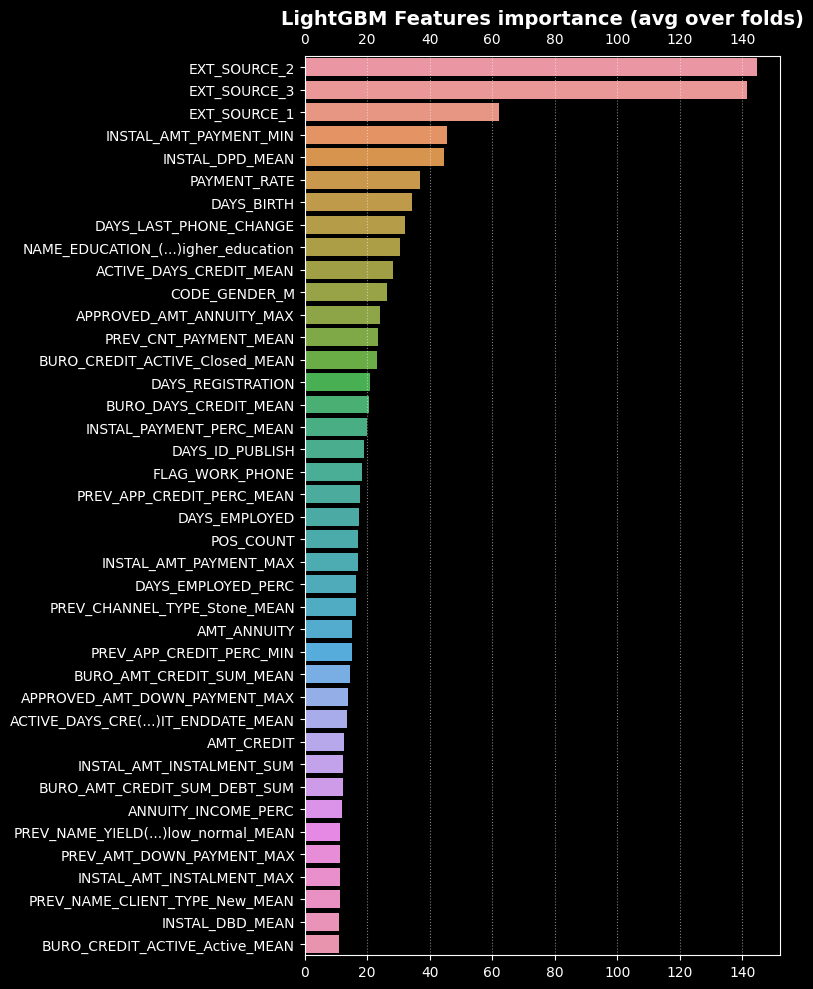

In [10]:
from home_credit.lightgbm_kernel_v2 import display_importances
selected_best_feats = display_importances(feat_imps)

### Affichage des scores par pli et globaux

In [11]:
display(scores)

{'F2': {'over_folds': [0.0,
   0.019230769230769232,
   0.008787346221441126,
   0.0,
   0.0],
  'overall': 0.005472455308281649},
 'AUC': {'over_folds': [0.7307598897762831,
   0.7596071442483737,
   0.7506489220312376,
   0.7463495075449534,
   0.765373946002362],
  'overall': 0.7505985643315459}}

### Affichage de la courbe ROC

overall AUC verif: 0.7505985643315459


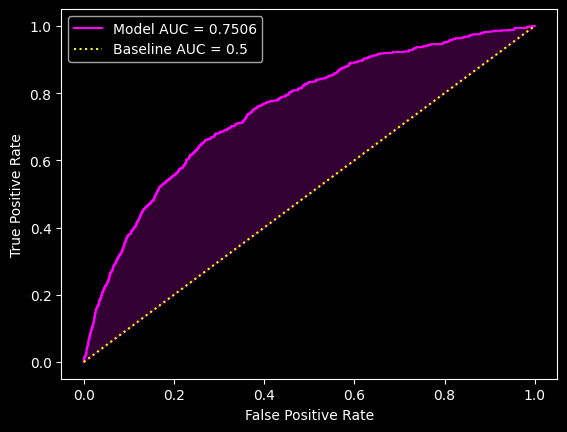

In [12]:
from home_credit.best_model_search import plot_roc_curve
from sklearn.metrics import roc_auc_score
y_train = res["resamples"]["y_train"]
train_pred_proba = res["preds"]["train"]["proba"]
overall_auc = res["scores"]['AUC']['overall']
print("overall AUC verif:", roc_auc_score(y_train, train_pred_proba))
plot_roc_curve(y_train, train_pred_proba, overall_auc)

## Effet du r√©-√©chantillonage

<mark>**TODO** Faire taire les traces de LGBM si verbosity=0 (apr√®s soutenance)</mark>

In [13]:
from home_credit.load import load_prep_dataset
from home_credit.best_model_search import kfold_train_and_eval_model
from home_credit.lightgbm_kernel_v2 import get_opt_lgbm_classifier

data = load_prep_dataset("baseline_v1")
data = data.sample(10_000)
clf = get_opt_lgbm_classifier()
res = kfold_train_and_eval_model(
    data, clf, scaler=None,
    verbosity=3
)


Starting train and eval of:
Labeled dataset of shape: (10000, 790)
Features set of shape: (10000, 788)

With:
Classifier: 


LGBMClassifier(callbacks=None, colsample_bytree=0.9497036, learning_rate=0.02,
               max_depth=8, min_child_weight=39.3259775,
               min_split_gain=0.0222415, n_estimators=10000, n_jobs=4,
               num_leaves=34, reg_alpha=0.041545473, reg_lambda=0.0735294,
               subsample=0.8715623)

Loss function: 


{'AUC': <function sklearn.metrics._ranking.roc_auc_score(y_true, y_score, *, average='macro', sample_weight=None, max_fpr=None, multi_class='raise', labels=None)>}

Eval metrics: 


{'F2': <function home_credit.best_model_search.<lambda>(y_valid, y_pred)>,
 'AUC': <function sklearn.metrics._ranking.roc_auc_score(y_true, y_score, *, average='macro', sample_weight=None, max_fpr=None, multi_class='raise', labels=None)>}

On 5 KFolds: 

Resampling
Sampler: 


SMOTETomek()

Original dataset shape: Counter({0.0: 7898, -1.0: 1379, 1.0: 723})
Resampled dataset shape: Counter({1.0: 7675, -1.0: 7665, 0.0: 7568})

Train vs. test subsets shapes
	Train shape: (15243, 788)
	Test shape: (7665, 788)

Evaluate the 1-th fold (on 5)
[200]	training's binary_logloss: 0.144589	valid_1's binary_logloss: 0.18575
[400]	training's binary_logloss: 0.104959	valid_1's binary_logloss: 0.164252
[600]	training's binary_logloss: 0.0884584	valid_1's binary_logloss: 0.161597
[800]	training's binary_logloss: 0.0772599	valid_1's binary_logloss: 0.16088
[1000]	training's binary_logloss: 0.0688881	valid_1's binary_logloss: 0.160776
Fold  0 F2: 0.915981
Fold  0 AUC: 0.974638

Evaluate the 2-th fold (on 5)
[200]	training's binary_logloss: 0.148935	valid_1's binary_logloss: 0.169165
[400]	training's binary_logloss: 0.109097	valid_1's binary_logloss: 0.143482
[600]	training's binary_logloss: 0.0922306	valid_1's binary_logloss: 0.137708
[800]	training's binary_logloss: 0.0808292	valid_1's bina

Avec un AUC de 0.98, il y a probablement du sur-apprentissage, ce qui n'est surprenant avec une √©chentillon aussi r√©duit.

Cela dit, l'impact du r√©√©quilibrage des classes est manifeste.

overall AUC verif: 0.981197102836562


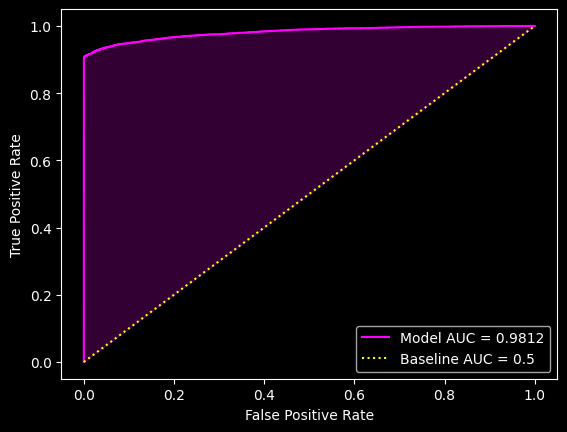

In [14]:
from home_credit.best_model_search import plot_roc_curve
from sklearn.metrics import roc_auc_score
y_train = res["resamples"]["y_train"]
train_pred_proba = res["preds"]["train"]["proba"]
overall_auc = res["scores"]['AUC']['overall']
print("overall AUC verif:", roc_auc_score(y_train, train_pred_proba))
plot_roc_curve(y_train, train_pred_proba, overall_auc)

Matrice de confusion


Confusion matrix


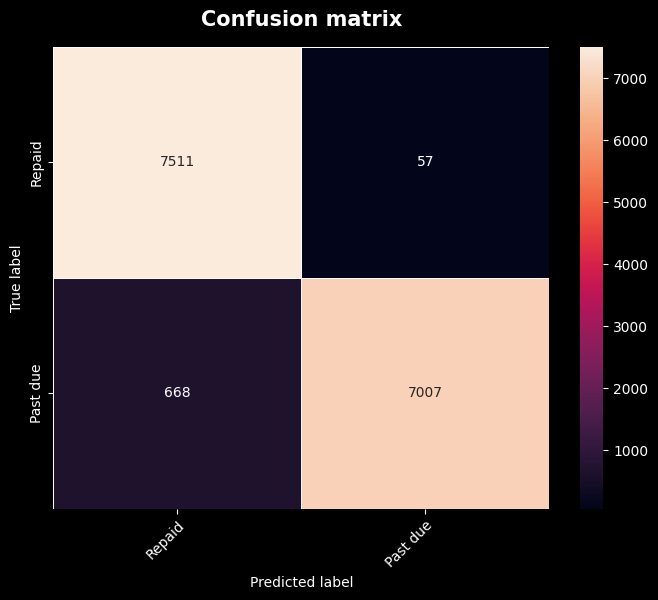

In [15]:
from pepper.scoring import show_confusion_matrix
y_train = res["resamples"]["y_train"]
train_pred_discr = res["preds"]["train"]["discr"]
show_confusion_matrix(y_train, train_pred_discr, ["Repaid", "Past due"])

Importance des caract√©ristiques

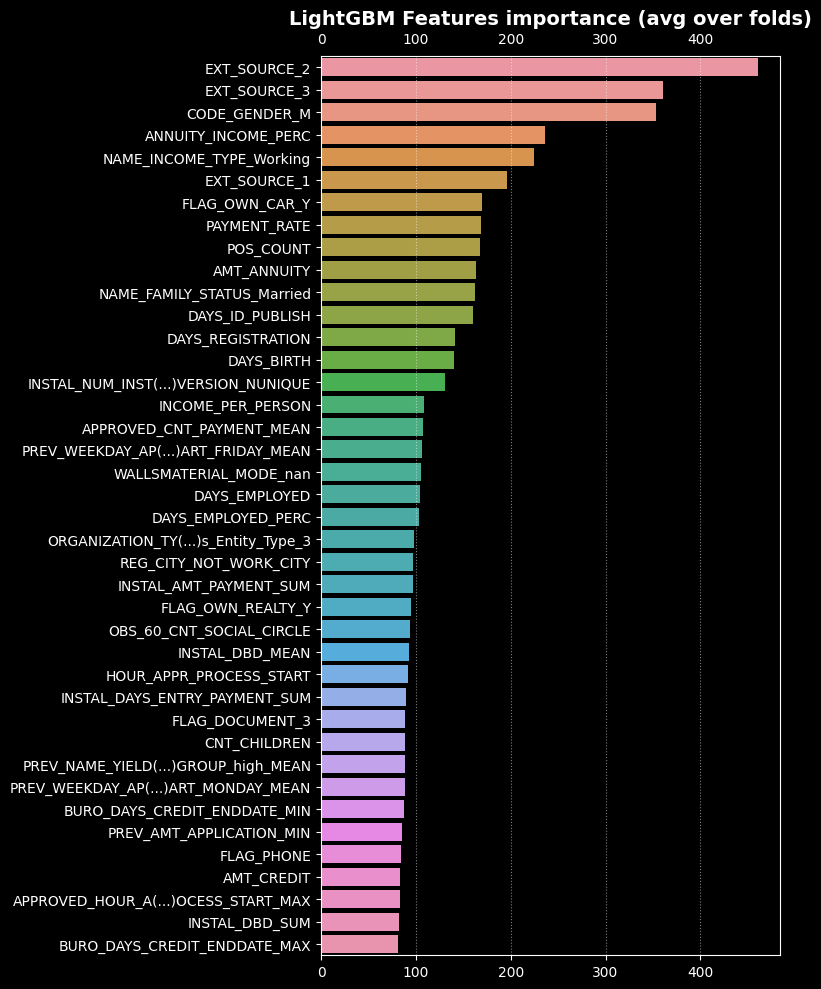

In [16]:
from home_credit.lightgbm_kernel_v2 import display_importances
feat_imps = res["feat_imps"]
selected_best_feats = display_importances(feat_imps)

## Effet de la mise √† l'√©chelle

In [17]:
from home_credit.load import load_prep_dataset
from home_credit.best_model_search import kfold_train_and_eval_model
from home_credit.lightgbm_kernel_v2 import get_opt_lgbm_classifier

data = load_prep_dataset("baseline_v1")
data = data.sample(10_000)
clf = get_opt_lgbm_classifier()
res = kfold_train_and_eval_model(
    data, clf,
    verbosity=3
)


Starting train and eval of:
Labeled dataset of shape: (10000, 790)
Features set of shape: (10000, 788)

With:
Classifier: 


LGBMClassifier(callbacks=None, colsample_bytree=0.9497036, learning_rate=0.02,
               max_depth=8, min_child_weight=39.3259775,
               min_split_gain=0.0222415, n_estimators=10000, n_jobs=4,
               num_leaves=34, reg_alpha=0.041545473, reg_lambda=0.0735294,
               subsample=0.8715623)

Loss function: 


{'AUC': <function sklearn.metrics._ranking.roc_auc_score(y_true, y_score, *, average='macro', sample_weight=None, max_fpr=None, multi_class='raise', labels=None)>}

Eval metrics: 


{'F2': <function home_credit.best_model_search.<lambda>(y_valid, y_pred)>,
 'AUC': <function sklearn.metrics._ranking.roc_auc_score(y_true, y_score, *, average='macro', sample_weight=None, max_fpr=None, multi_class='raise', labels=None)>}

On 5 KFolds: 

Resampling
Sampler: 


SMOTETomek()

Original dataset shape: Counter({0.0: 7975, -1.0: 1351, 1.0: 674})
Resampled dataset shape: Counter({1.0: 7763, -1.0: 7715, 0.0: 7649})

Train vs. test subsets shapes
	Train shape: (15412, 788)
	Test shape: (7715, 788)

Evaluate the 1-th fold (on 5)
[200]	training's binary_logloss: 0.136921	valid_1's binary_logloss: 0.167385
[400]	training's binary_logloss: 0.0999356	valid_1's binary_logloss: 0.145967
[600]	training's binary_logloss: 0.0838234	valid_1's binary_logloss: 0.142088
[800]	training's binary_logloss: 0.0730306	valid_1's binary_logloss: 0.1403
[1000]	training's binary_logloss: 0.0650174	valid_1's binary_logloss: 0.139803
[1200]	training's binary_logloss: 0.0588551	valid_1's binary_logloss: 0.13964
Fold  0 F2: 0.926587
Fold  0 AUC: 0.980849

Evaluate the 2-th fold (on 5)
[200]	training's binary_logloss: 0.138072	valid_1's binary_logloss: 0.160322
[400]	training's binary_logloss: 0.10187	valid_1's binary_logloss: 0.136074
[600]	training's binary_logloss: 0.0859553	valid_1's bina

overall AUC verif: 0.9822982186560667


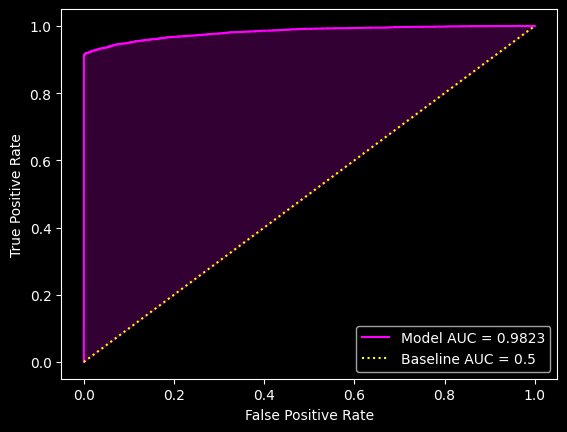

In [3]:
from home_credit.best_model_search import plot_roc_curve
from sklearn.metrics import roc_auc_score
y_train = res["resamples"]["y_train"]
train_pred_proba = res["preds"]["train"]["proba"]
overall_auc = res["scores"]['AUC']['overall']
print("overall AUC verif:", roc_auc_score(y_train, train_pred_proba))
plot_roc_curve(y_train, train_pred_proba, overall_auc)

Matrice de confusion


Confusion matrix


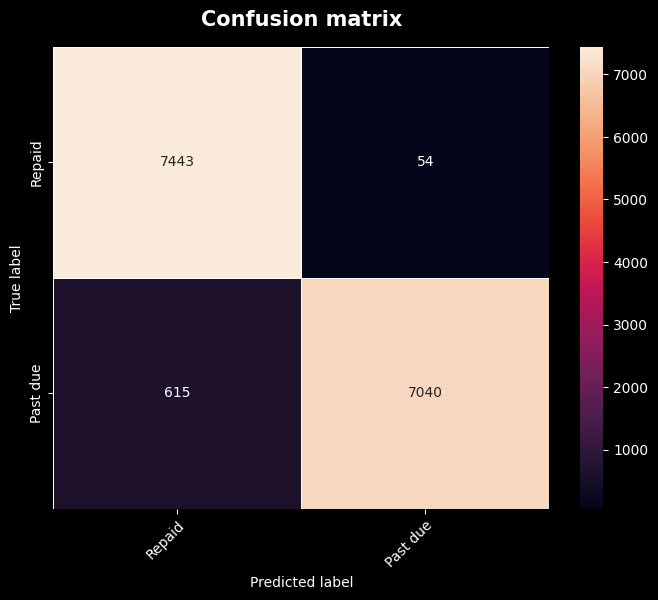

In [6]:
from pepper.scoring import show_confusion_matrix
y_train = res["resamples"]["y_train"]
train_pred_discr = res["preds"]["train"]["discr"]
show_confusion_matrix(y_train, train_pred_discr, ["Repaid", "Past due"])

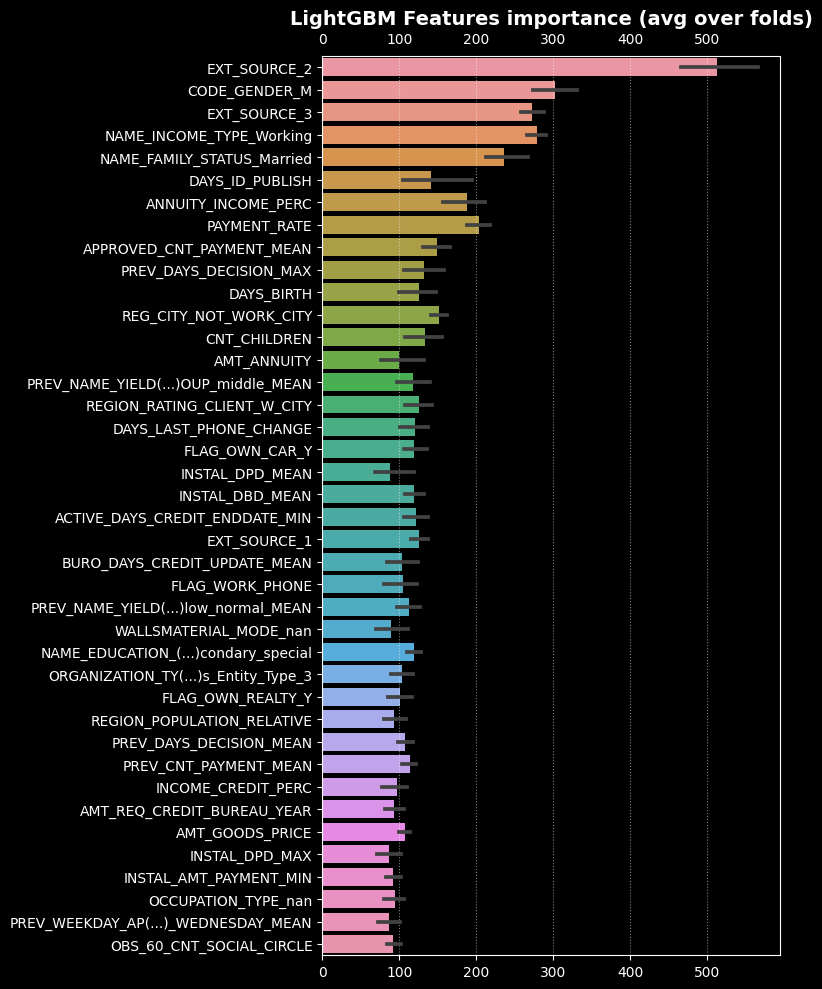

In [9]:
from home_credit.lightgbm_kernel_v2 import display_importances
feat_imps = res["feat_imps"]
selected_best_feats = display_importances(feat_imps)

# Benchmark des mod√®les

## Mod√©le de r√©f√©rence : classifieur na√Øf

Nous utilisons un [**`DummyClassifier`**](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html) de Scikit-learn param√©tr√© avec `strategy="most_frequent"`.

Param√©tr√© avec cette strat√©gie, le classifieur na√Øf pr√©dira syst√©matiquement la classe dominante.

Ce classifieur va nous servir de base de r√©f√©rence √† laquelle comparer les performances pr√©dictives de classifieurs plus avanc√©s.

Le classifieur na√Øf donne n√©cessairement un score AUC ROC de 0,5 [[**StackExchange** > *Can AUC-ROC be between 0-0.5?*](https://stats.stackexchange.com/questions/266387/can-auc-roc-be-between-0-0-5)].

In [ ]:
import numpy as np
from sklearn.dummy import DummyClassifier
X = np.array([-1, 1, 1, 1])
y = np.array([0, 1, 1, 1])
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X, y)
dummy_clf.predict(X)
dummy_clf.score(X, y)

0.75

## R√©gression Logistique

R√©f√©rences :
* http://faculty.marshall.usc.edu/gareth-james/ => n'est plus accessible
* https://www.oreilly.com/library/view/hands-on-machine-learning/9781491962282/ => pas gratuit

Ici, je me concentrerai sur la mise en ≈ìuvre du mod√®le plut√¥t que sur l'explication des d√©tails, mais pour ceux qui veulent en savoir plus sur la th√©orie des algorithmes d'apprentissage automatique, je recommande √† la fois "An Introduction to Statistical Learning" et "Hands-On Machine Learning with Scikit-Learn and TensorFlow". Ces deux livres pr√©sentent la th√©orie ainsi que le code n√©cessaire pour cr√©er les mod√®les (en R et en Python respectivement). Ils enseignent tous deux avec l'id√©e que la meilleure fa√ßon d'apprendre est de faire, et ils sont tr√®s efficaces!

Pour obtenir une base de r√©f√©rence, nous utiliserons toutes les caract√©ristiques, apr√®s encodage des variables cat√©gorielles. Nous pr√©traiterons les donn√©es en remplissant les valeurs manquantes (imputation) et en normalisant la plage des caract√©ristiques (mise √† l'√©chelle des caract√©ristiques). Le code suivant effectue ces deux √©tapes de pr√©traitement.

----

La r√©gression logistique de scikit-learn n'a pas de m√©thode int√©gr√©e pour r√©cup√©rer les importances de caract√©ristiques (*feature importances*) comme c'est le cas pour les mod√®les de type arbre, tels que les RandomForest ou les XGBoost.

Cependant, il est possible d'approximer les importances de caract√©ristiques en utilisant les coefficients de r√©gression. Les coefficients indiquent l'importance relative de chaque caract√©ristique dans la pr√©diction de la variable cible. Plus un coefficient est grand, plus la caract√©ristique associ√©e est importante. Evidemment, cela ne tient que sous hypoth√®se que les donn√©es ont √©t√© pr√©alablement normalis√©es et sont donc √† la m√™me √©chelle.

Test sur l'√©chantillon de $10\,000$ avec r√©-√©chantillonnage et mise √† l'√©chelle par d√©faut.

In [1]:
from home_credit.load import load_prep_dataset
from home_credit.best_model_search import kfold_train_and_eval_model
from sklearn.linear_model import LogisticRegression

data = load_prep_dataset("baseline_v1")
data = data.sample(10_000)
clf = LogisticRegression(C=1e-4, random_state=42)
res = kfold_train_and_eval_model(
    data, clf,
    verbosity=3
)


Starting train and eval of:
Labeled dataset of shape: (10000, 790)
Features set of shape: (10000, 788)

With:
Classifier: 


LogisticRegression(C=0.0001, random_state=42)

Loss function: 


{'AUC': <function sklearn.metrics._ranking.roc_auc_score(y_true, y_score, *, average='macro', sample_weight=None, max_fpr=None, multi_class='raise', labels=None)>}

Eval metrics: 


{'F2': <function home_credit.best_model_search.<lambda>(y_valid, y_pred)>,
 'AUC': <function sklearn.metrics._ranking.roc_auc_score(y_true, y_score, *, average='macro', sample_weight=None, max_fpr=None, multi_class='raise', labels=None)>}

On 5 KFolds: 

Resampling
Sampler: 


SMOTETomek()

Original dataset shape: Counter({0.0: 7921, -1.0: 1399, 1.0: 680})
Resampled dataset shape: Counter({1.0: 7742, -1.0: 7655, 0.0: 7582})

Train vs. test subsets shapes
	Train shape: (15324, 788)
	Test shape: (7655, 788)

Evaluate the 1-th fold (on 5)
Fold  0 F2: 0.720709
Fold  0 AUC: 0.701474

Evaluate the 2-th fold (on 5)
Fold  1 F2: 0.736849
Fold  1 AUC: 0.698648

Evaluate the 3-th fold (on 5)
Fold  2 F2: 0.731494
Fold  2 AUC: 0.702636

Evaluate the 4-th fold (on 5)
Fold  3 F2: 0.713490
Fold  3 AUC: 0.711704

Evaluate the 5-th fold (on 5)
Fold  4 F2: 0.741157
Fold  4 AUC: 0.732343
Full F2: 0.728718
Full AUC: 0.708485


Courbe ROC et AUC :

overall AUC verif: 0.7084850855821695


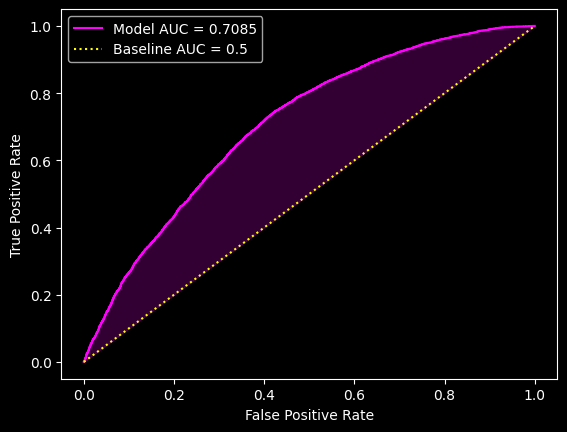

In [2]:
from home_credit.best_model_search import plot_roc_curve
from sklearn.metrics import roc_auc_score
y_train = res["resamples"]["y_train"]
train_pred_proba = res["preds"]["train"]["proba"]
overall_auc = res["scores"]['AUC']['overall']
print("overall AUC verif:", roc_auc_score(y_train, train_pred_proba))
plot_roc_curve(y_train, train_pred_proba, overall_auc)

Matrice de confusion


Confusion matrix


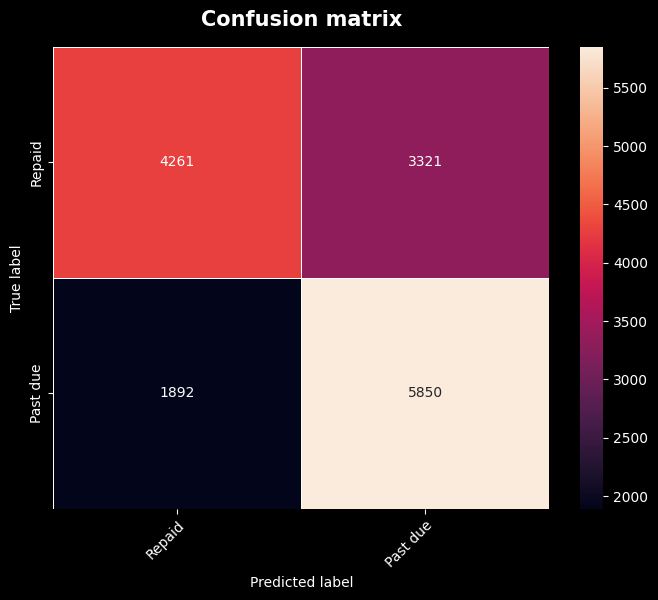

In [3]:
from pepper.scoring import show_confusion_matrix
y_train = res["resamples"]["y_train"]
train_pred_discr = res["preds"]["train"]["discr"]
show_confusion_matrix(y_train, train_pred_discr, ["Repaid", "Past due"])

feature  importance  fold
0                ACTIVE_AMT_ANNUITY_MAX   -0.000033     0
1               ACTIVE_AMT_ANNUITY_MEAN   -0.000145     0
2    ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN    0.000801     0
3        ACTIVE_AMT_CREDIT_SUM_DEBT_MAX   -0.000114     0
4       ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN   -0.000238     0
..                                  ...         ...   ...
783        YEARS_BEGINEXPLUATATION_MEDI   -0.000409     4
784        YEARS_BEGINEXPLUATATION_MODE   -0.000290     4
785                     YEARS_BUILD_AVG   -0.001552     4
786                    YEARS_BUILD_MEDI   -0.001620     4
787                    YEARS_BUILD_MODE   -0.001521     4

[3940 rows x 3 columns]

importance
feature                                                    
CODE_GENDER_M                                      0.031026
NAME_EDUCATION_TYPE_Secondary_secondary_special    0.030517
NAME_INCOME_TYPE_Working                           0.029999
DAYS_BIRTH                                         0.018470
BURO_DAYS_CREDIT_MIN                               0.018252
...                                                     ...
BURO_CREDIT_ACTIVE_Closed_MEAN                    -0.016998
NAME_FAMILY_STATUS_Married                        -0.019992
EXT_SOURCE_3                                      -0.029804
NAME_EDUCATION_TYPE_Higher_education              -0.032042
EXT_SOURCE_2                                      -0.042631

[788 rows x 1 columns]

feature  importance
0                                      CODE_GENDER_M    0.031026
1    NAME_EDUCATION_TYPE_Secondary_secondary_special    0.030517
2                           NAME_INCOME_TYPE_Working    0.029999
3                                         DAYS_BIRTH    0.018470
4                               BURO_DAYS_CREDIT_MIN    0.018252
..                                               ...         ...
783                   BURO_CREDIT_ACTIVE_Closed_MEAN   -0.016998
784                       NAME_FAMILY_STATUS_Married   -0.019992
785                                     EXT_SOURCE_3   -0.029804
786             NAME_EDUCATION_TYPE_Higher_education   -0.032042
787                                     EXT_SOURCE_2   -0.042631

[788 rows x 2 columns]

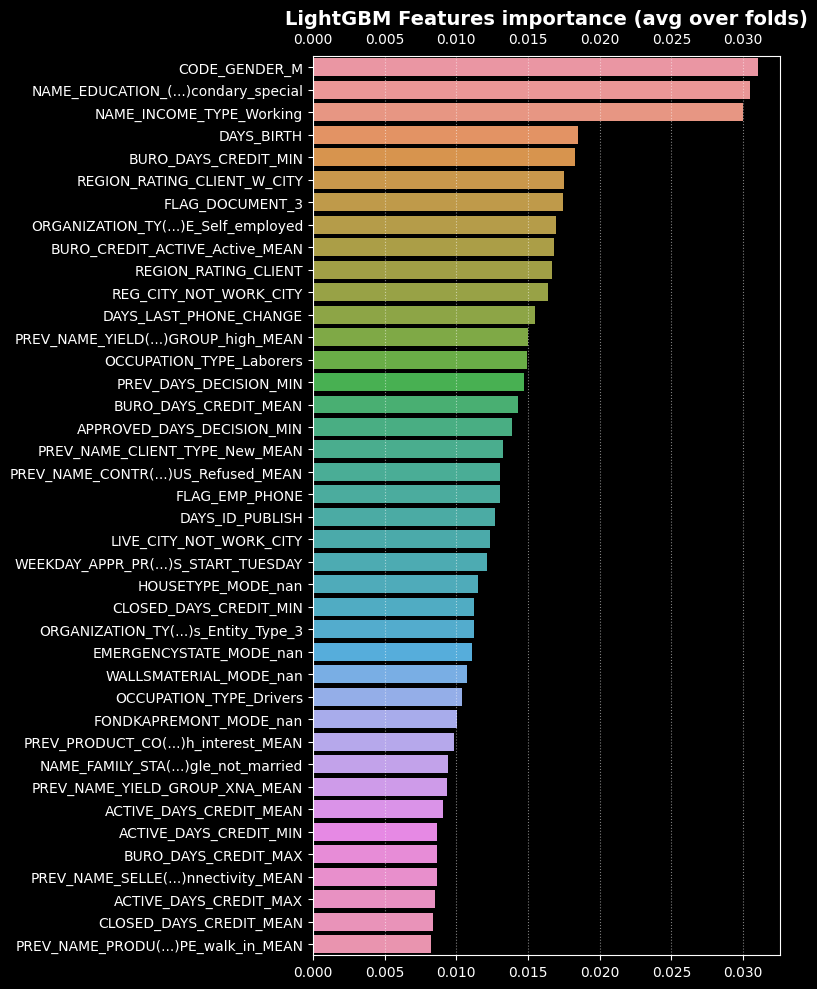

In [4]:
from home_credit.lightgbm_kernel_v2 import display_importances
feat_imps = res["feat_imps"]
selected_best_feats = display_importances(feat_imps)

R√©f√©rences :
* https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
* https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

Nous allons utiliser la [**`LogisticRegression` de Scikit-Learn**](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) pour notre premier mod√®le. La seule modification que nous apporterons aux param√®tres par d√©faut du mod√®le sera de baisser le [**param√®tre de r√©gularisation, C**](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression), qui contr√¥le le niveau de sur-apprentissage (une valeur plus faible devrait diminuer le sur-apprentissage). Cela nous donnera des r√©sultats l√©g√®rement meilleurs que la `LogisticRegression` par d√©faut, mais cela fixera tout de m√™me une barre basse pour tous les mod√®les futurs.

Ici, nous utilisons la syntaxe famili√®re de mod√©lisation de Scikit-Learn : nous cr√©ons d'abord le mod√®le, puis nous l'entra√Ænons en utilisant `.fit` et ensuite nous faisons des pr√©dictions sur les donn√©es de test en utilisant `.predict_proba` (rappelez-vous que nous voulons des probabilit√©s et non un 0 ou 1).

Maintenant que le mod√®le a √©t√© entra√Æn√©, nous pouvons l'utiliser pour faire des pr√©dictions. Nous voulons pr√©dire les probabilit√©s de non-remboursement d'un pr√™t, donc nous utilisons la m√©thode predict.proba du mod√®le. Cela renvoie un tableau de dimensions m x 2 o√π m est le nombre d'observations. La premi√®re colonne est la probabilit√© que la cible soit 0 et la deuxi√®me colonne est la probabilit√© que la cible soit 1 (donc pour une seule ligne, les deux colonnes doivent s'additionner √† 1). Nous voulons la probabilit√© que le pr√™t ne soit pas rembours√©, donc nous s√©lectionnons la deuxi√®me colonne.

Le code suivant effectue les pr√©dictions et s√©lectionne la bonne colonne.

In [ ]:
# Save the submission to a csv file
submit.to_csv('log_reg_baseline.csv', index=False)

La soumission a maintenant √©t√© sauvegard√©e dans l'environnement virtuel dans lequel notre notebook s'ex√©cute. Pour acc√©der √† la soumission, √† la fin du notebook, nous appuierons sur le bouton bleu "Commit & Run" en haut √† droite du noyau. Cela ex√©cute l'ensemble du notebook, puis nous permet de t√©l√©charger tous les fichiers qui ont √©t√© cr√©√©s pendant l'ex√©cution.

Une fois que nous avons ex√©cut√© le notebook, les fichiers cr√©√©s sont disponibles dans l'onglet "Versions" sous l'onglet "Output". √Ä partir de l√†, les fichiers de soumission peuvent √™tre soumis √† la comp√©tition ou t√©l√©charg√©s. Comme il y a plusieurs mod√®les dans ce notebook, il y aura plusieurs fichiers de sortie.

**Le score de base de la r√©gression logistique devrait √™tre d'environ 0,671 lorsqu'il est soumis.**

## Mod√®le am√©lior√© : For√™t al√©atoire

Pour essayer de battre les mauvaises performances de notre mod√®le de base, nous pouvons mettre √† jour l'algorithme. Essayons d'utiliser une for√™t al√©atoire sur les m√™mes donn√©es d'entra√Ænement pour voir comment cela affecte les performances. La for√™t al√©atoire est un mod√®le beaucoup plus puissant que la r√©gression logistique, surtout lorsque nous utilisons des centaines d'arbres. Nous utiliserons 100 arbres dans la for√™t al√©atoire.

Ces pr√©visions seront √©galement disponibles lorsque nous ex√©cuterons l'ensemble du notebook.

**Ce mod√®le devrait avoir un score d'environ 0,678 lorsqu'il est soumis.**

In [2]:
from home_credit.load import load_prep_dataset
from home_credit.best_model_search import kfold_train_and_eval_model
from sklearn.ensemble import RandomForestClassifier

data = load_prep_dataset("baseline_v1")
data = data.sample(10_000)

# Create the random forest classifier
clf = RandomForestClassifier(
    n_estimators=100, random_state=42,
    verbose=1, n_jobs=-1
)

# Train and cross eval it
res = kfold_train_and_eval_model(
    data, clf,
    verbosity=3
)


Starting train and eval of:
Labeled dataset of shape: (10000, 790)
Features set of shape: (10000, 788)

With:
Classifier: 


RandomForestClassifier(n_jobs=-1, random_state=42, verbose=1)

Loss function: 


{'AUC': <function sklearn.metrics._ranking.roc_auc_score(y_true, y_score, *, average='macro', sample_weight=None, max_fpr=None, multi_class='raise', labels=None)>}

Eval metrics: 


{'F2': <function home_credit.best_model_search.<lambda>(y_valid, y_pred)>,
 'AUC': <function sklearn.metrics._ranking.roc_auc_score(y_true, y_score, *, average='macro', sample_weight=None, max_fpr=None, multi_class='raise', labels=None)>}

On 5 KFolds: 

Resampling
Sampler: 


SMOTETomek()

Original dataset shape: Counter({0.0: 7891, -1.0: 1373, 1.0: 736})
Resampled dataset shape: Counter({1.0: 7713, -1.0: 7632, 0.0: 7566})

Train vs. test subsets shapes
	Train shape: (15279, 788)
	Test shape: (7632, 788)

Evaluate the 1-th fold (on 5)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


Fold  0 F2: 0.940910
Fold  0 AUC: 0.994281

Evaluate the 2-th fold (on 5)


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.9s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


Fold  1 F2: 0.942714
Fold  1 AUC: 0.992358

Evaluate the 3-th fold (on 5)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


Fold  2 F2: 0.934510
Fold  2 AUC: 0.993590

Evaluate the 4-th fold (on 5)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


Fold  3 F2: 0.929779
Fold  3 AUC: 0.991059

Evaluate the 5-th fold (on 5)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.4s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s


Fold  4 F2: 0.934308
Fold  4 AUC: 0.991845
Full F2: 0.936422
Full AUC: 0.992594


[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


Courbe ROC et AUC :

overall AUC verif: 0.9925937030076379


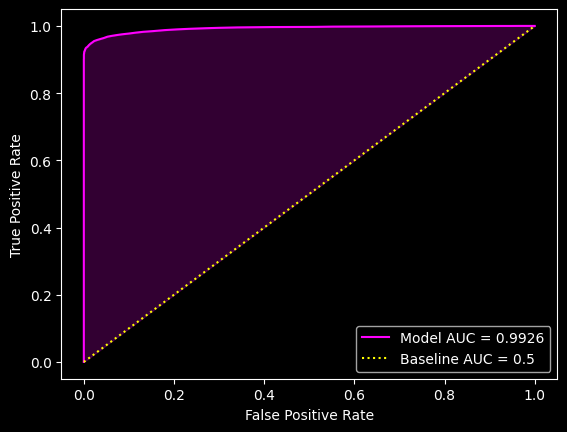

In [3]:
from home_credit.best_model_search import plot_roc_curve
from sklearn.metrics import roc_auc_score
y_train = res["resamples"]["y_train"]
train_pred_proba = res["preds"]["train"]["proba"]
overall_auc = res["scores"]['AUC']['overall']
print("overall AUC verif:", roc_auc_score(y_train, train_pred_proba))
plot_roc_curve(y_train, train_pred_proba, overall_auc)

Matrice de confusion


Confusion matrix


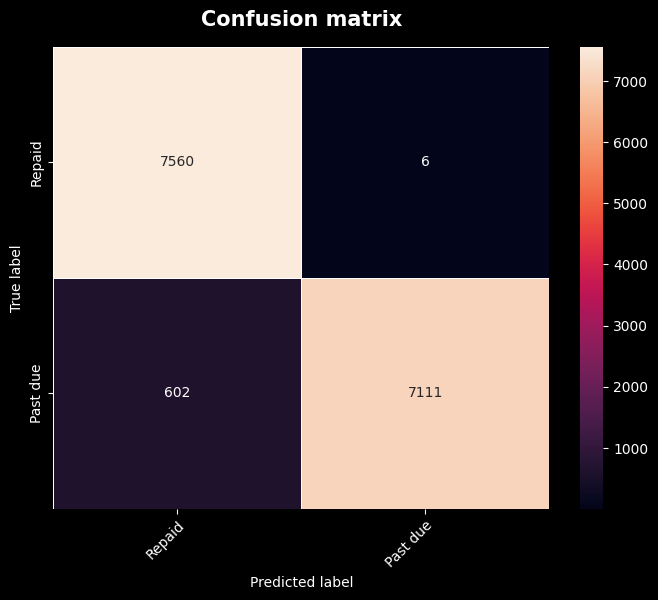

In [4]:
from pepper.scoring import show_confusion_matrix
y_train = res["resamples"]["y_train"]
train_pred_discr = res["preds"]["train"]["discr"]
show_confusion_matrix(y_train, train_pred_discr, ["Repaid", "Past due"])

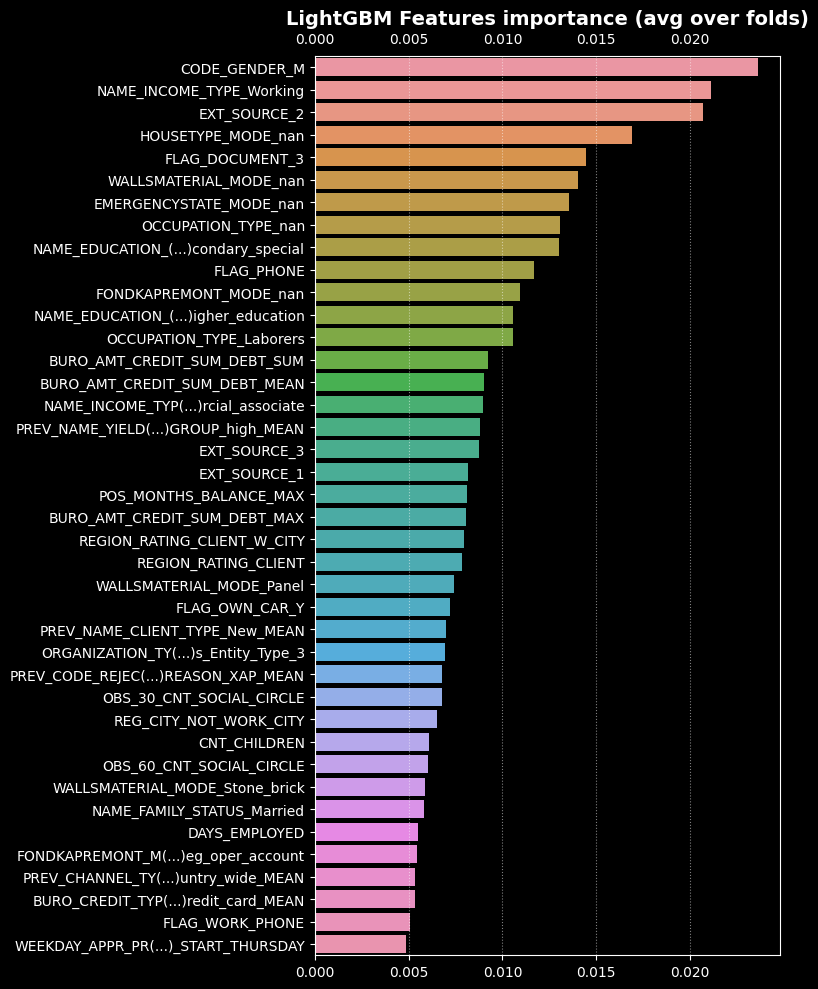

In [5]:
from home_credit.lightgbm_kernel_v2 import display_importances
feat_imps = res["feat_imps"]
selected_best_feats = display_importances(feat_imps)

## Mod√®le de performance : LGBM

Nous l'avons d√©j√† √©tudi√© appr√©ci√© plus haut, il a √©t√© notre base de d√©part.

# Importances des caract√©ristiques et explication de mod√®le

Valeurs de Shapeley et SHAP

https://shap.readthedocs.io/en/latest/index.html

RuntimeError: Cannot install on Python version 3.11.1; only versions >=3.7,<3.11 are supported.

SHAP fait partie des retardataires.

## Explication de la r√©gression logistique

Ex√©cution de la r√©gression logistique :

On r√©cup√®re le classifieur entra√Æn√© et on interpr√®te √† l'aide de SHAP ce qu'il se passe √† l'√©chelle de l'ensemble du jeu de donn√©es.

In [6]:
from home_credit.load import load_prep_dataset
from home_credit.best_model_search import kfold_train_and_eval_model
from sklearn.linear_model import LogisticRegression

data = load_prep_dataset("baseline_v1")
sample_10k = data.sample(10_000)
clf = LogisticRegression(C=1e-4, random_state=42)
res = kfold_train_and_eval_model(
    sample_10k, clf,
    verbosity=1,
    return_trained_clf=True
)

Starting train and eval of:
Labeled dataset of shape: (10000, 790)
Features set of shape: (10000, 788)
With:
Classifier: 


LogisticRegression(C=0.0001, random_state=42)

Loss function: 


{'AUC': <function sklearn.metrics._ranking.roc_auc_score(y_true, y_score, *, average='macro', sample_weight=None, max_fpr=None, multi_class='raise', labels=None)>}

Eval metrics: 


{'F2': <function home_credit.best_model_search.<lambda>(y_valid, y_pred)>,
 'AUC': <function sklearn.metrics._ranking.roc_auc_score(y_true, y_score, *, average='macro', sample_weight=None, max_fpr=None, multi_class='raise', labels=None)>}

On 5 KFolds: 
Sampler: 


SMOTETomek()

Original dataset shape: Counter({0.0: 7880, -1.0: 1439, 1.0: 681})
Resampled dataset shape: Counter({1.0: 7732, -1.0: 7623, 0.0: 7563})
	Train shape: (15295, 788)
	Test shape: (7623, 788)
Fold  0 F2: 0.768374
Fold  0 AUC: 0.709677
Fold  1 F2: 0.688719
Fold  1 AUC: 0.674584
Fold  2 F2: 0.711875
Fold  2 AUC: 0.691724
Fold  3 F2: 0.721076
Fold  3 AUC: 0.699175
Fold  4 F2: 0.704945
Fold  4 AUC: 0.688924
Full F2: 0.719011
Full AUC: 0.691448


Interpr√©tation bas√©e sur les valeurs de Shapley (avec SHAP) :

In [8]:
display(res["trained_clf"])

LogisticRegression(C=0.0001, random_state=42)

In [11]:
def logreg_predict_proba(clf, x):
    return clf.predict_proba(x)[:,1]

def logreg_log_odds(clf, x):
    p = clf.predict_log_proba(x)
    return p[:,1] - p[:,0]

In [14]:
display(data)

SK_ID_CURR  TARGET  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
0           100002       1             0          202500.0    406597.5   
1           100003       0             0          270000.0   1293502.5   
2           100004       0             0           67500.0    135000.0   
3           100006       0             0          135000.0    312682.5   
4           100007       0             0          121500.0    513000.0   
...            ...     ...           ...               ...         ...   
356250      456221      -1             0          121500.0    412560.0   
356251      456222      -1             2          157500.0    622413.0   
356252      456223      -1             1          202500.0    315000.0   
356253      456224      -1             0          225000.0    450000.0   
356254      456250      -1             0          135000.0    312768.0   

        AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
0           24700.5         351000.0                    0.018801       -9461   
1           35698.5        1129500.0                    0.003541      -16765   
2            6750.0         135000.0                    0.010032      -19046   
3           29686.5         297000.0                    0.008019      -19005   
4           21865.5         513000.0                    0.028663      -19932   
...             ...              ...                         ...         ...   
356250      17473.5         270000.0                    0.002042      -19970   
356251      31909.5         495000.0                    0.035792      -11186   
356252      33205.5         315000.0                    0.026392      -15922   
356253      25128.0         450000.0                    0.018850      -13968   
356254      24709.5         270000.0                    0.006629      -13962   

        DAYS_EMPLOYED  ...  CC_NAME_CONTRACT_STATUS_Sent_proposal_MIN_nan  \
0                -637  ...                                           True   
1               -1188  ...                                           True   
2                -225  ...                                           True   
3               -3039  ...                                          False   
4               -3038  ...                                           True   
...               ...  ...                                            ...   
356250          -5169  ...                                           True   
356251          -1149  ...                                           True   
356252          -3037  ...                                           True   
356253          -2731  ...                                           True   
356254           -633  ...                                          False   

        CC_NAME_CONTRACT_STATUS_Sent_proposal_MAX_False  \
0                                                 False   
1                                                 False   
2                                                 False   
3                                                  True   
4                                                 False   
...                                                 ...   
356250                                            False   
356251                                            False   
356252                                            False   
356253                                            False   
356254                                             True   

        CC_NAME_CONTRACT_STATUS_Sent_proposal_MAX_True  \
0                                                False   
1                                                False   
2                                                False   
3                                                False   
4                                                False   
...                                                ...   
356250                                           False   
356251                                           False   
35

In [13]:
import shap

# Exclude non-feature columns
not_feat_names = ["TARGET", "SK_ID_CURR", "SK_ID_BUREAU", "SK_ID_PREV", "index"]
feat_names = data.columns.difference(not_feat_names)
X = data[feat_names]
y = data.TARGET

# make a standard partial dependence plot
sample_ind = 18
fig,ax = shap.partial_dependence_plot(
    "CODE_GENDER_M", logreg_predict_proba, X, model_expected_value=True,
    feature_expected_value=True, show=False, ice=False
)

TypeError: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

In [15]:
explainer = shap.TreeExplainer(clf)
display(explainer)

InvalidModelError: Model type not yet supported by TreeExplainer: <class 'sklearn.linear_model._logistic.LogisticRegression'>

## Explication du mod√®le LGBM

In [20]:
from home_credit.load import load_prep_dataset
from home_credit.best_model_search import kfold_train_and_eval_model
from home_credit.lightgbm_kernel_v2 import get_opt_lgbm_classifier

data = load_prep_dataset("baseline_v1")
sample_10k = data.sample(10_000)
clf = get_opt_lgbm_classifier()
res = kfold_train_and_eval_model(
    sample_10k, clf,
    verbosity=1,
    return_trained_clf=True
)

Starting train and eval of:
Labeled dataset of shape: (10000, 790)
Features set of shape: (10000, 788)
With:
Classifier: 


LGBMClassifier(callbacks=None, colsample_bytree=0.9497036, learning_rate=0.02,
               max_depth=8, min_child_weight=39.3259775,
               min_split_gain=0.0222415, n_estimators=10000, n_jobs=4,
               num_leaves=34, reg_alpha=0.041545473, reg_lambda=0.0735294,
               subsample=0.8715623)

Loss function: 


{'AUC': <function sklearn.metrics._ranking.roc_auc_score(y_true, y_score, *, average='macro', sample_weight=None, max_fpr=None, multi_class='raise', labels=None)>}

Eval metrics: 


{'F2': <function home_credit.best_model_search.<lambda>(y_valid, y_pred)>,
 'AUC': <function sklearn.metrics._ranking.roc_auc_score(y_true, y_score, *, average='macro', sample_weight=None, max_fpr=None, multi_class='raise', labels=None)>}

On 5 KFolds: 
Sampler: 


SMOTETomek()

Original dataset shape: Counter({0.0: 7929, -1.0: 1382, 1.0: 689})
Resampled dataset shape: Counter({1.0: 7718, -1.0: 7687, 0.0: 7592})
	Train shape: (15310, 788)
	Test shape: (7687, 788)
[200]	training's binary_logloss: 0.14362	valid_1's binary_logloss: 0.160164
[400]	training's binary_logloss: 0.105498	valid_1's binary_logloss: 0.135968
[600]	training's binary_logloss: 0.0888959	valid_1's binary_logloss: 0.131345
[800]	training's binary_logloss: 0.0776405	valid_1's binary_logloss: 0.129553
[1000]	training's binary_logloss: 0.0691532	valid_1's binary_logloss: 0.128319
[1200]	training's binary_logloss: 0.062559	valid_1's binary_logloss: 0.127621
Fold  0 F2: 0.937170
Fold  0 AUC: 0.983726
[200]	training's binary_logloss: 0.14207	valid_1's binary_logloss: 0.163544
[400]	training's binary_logloss: 0.103995	valid_1's binary_logloss: 0.140456
[600]	training's binary_logloss: 0.0879184	valid_1's binary_logloss: 0.135803
[800]	training's binary_logloss: 0.0768787	valid_1's binary_logloss: 0.1

In [22]:
import shap

# Exclude non-feature columns
not_feat_names = ["TARGET", "SK_ID_CURR", "SK_ID_BUREAU", "SK_ID_PREV", "index"]
feat_names = data.columns.difference(not_feat_names)
X = data[feat_names]
y = data.TARGET

explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X)  # TODO : X_test plut√¥t, non ?

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [23]:
shap.initjs()
shap.force_plot(
    explainer.expected_value[0], shap_values[0][0,:], 
    features=X.iloc[0, :])

In [25]:
import numpy as np
print(f'shape of test dataset: {X.shape}')
print(f'type of shap_values: {type(shap_values)}. length of the list: {len(shap_values)}')
print(f'shape of shap_values: {np.array(shap_values).shape}')

shape of test dataset: (356255, 788)
type of shap_values: <class 'list'>. length of the list: 2
shape of shap_values: (2, 356255, 788)


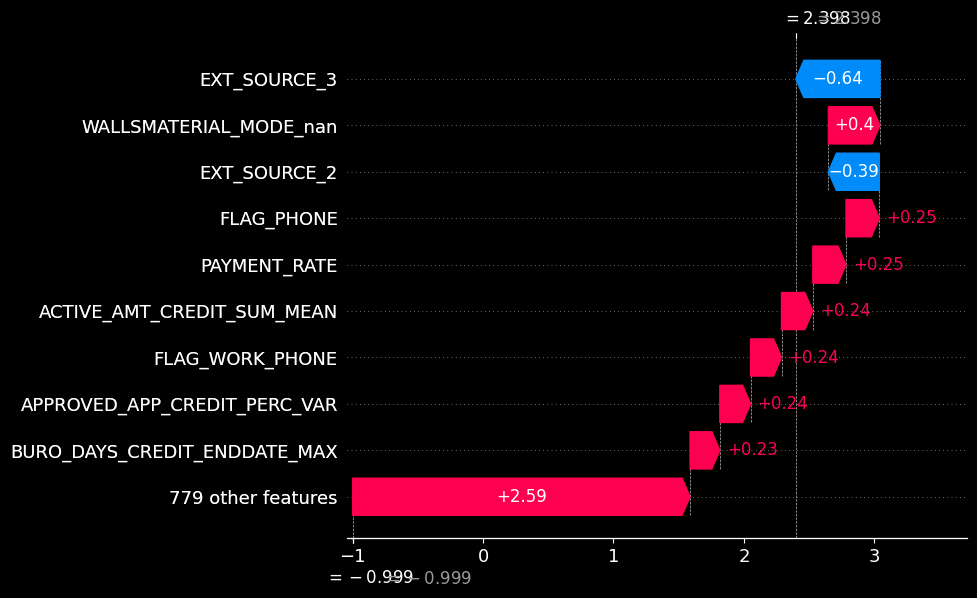

In [26]:
shap.plots._waterfall.waterfall_legacy(
    explainer.expected_value[0],
    shap_values[0][0], 
    feature_names=X.columns
)

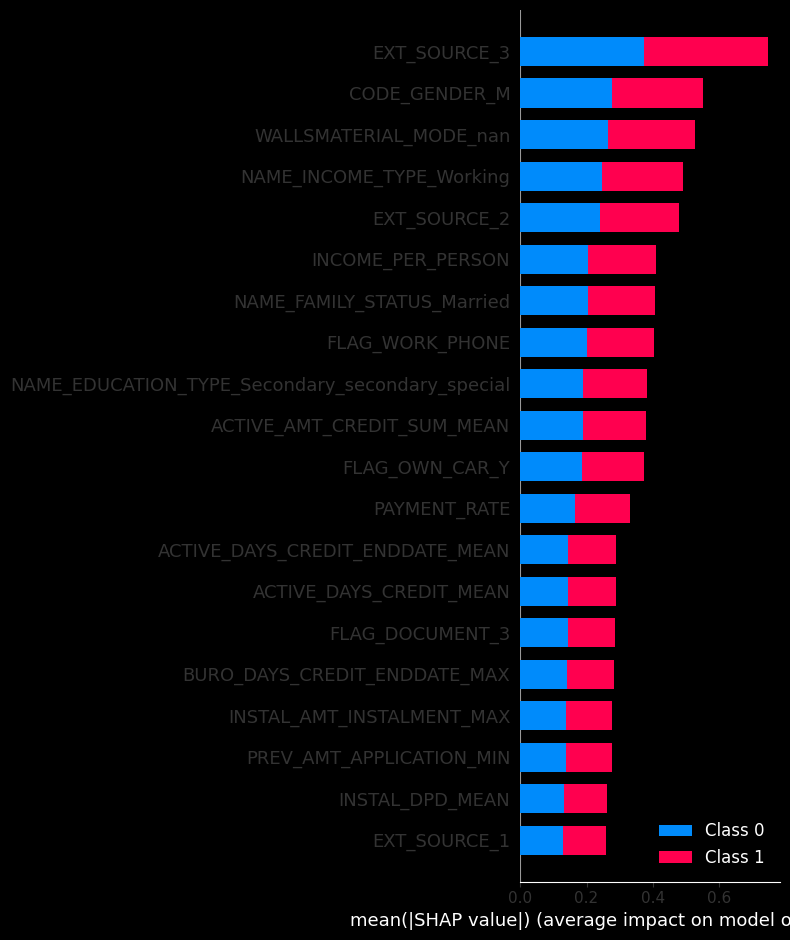

In [27]:
shap.summary_plot(shap_values, features=X)

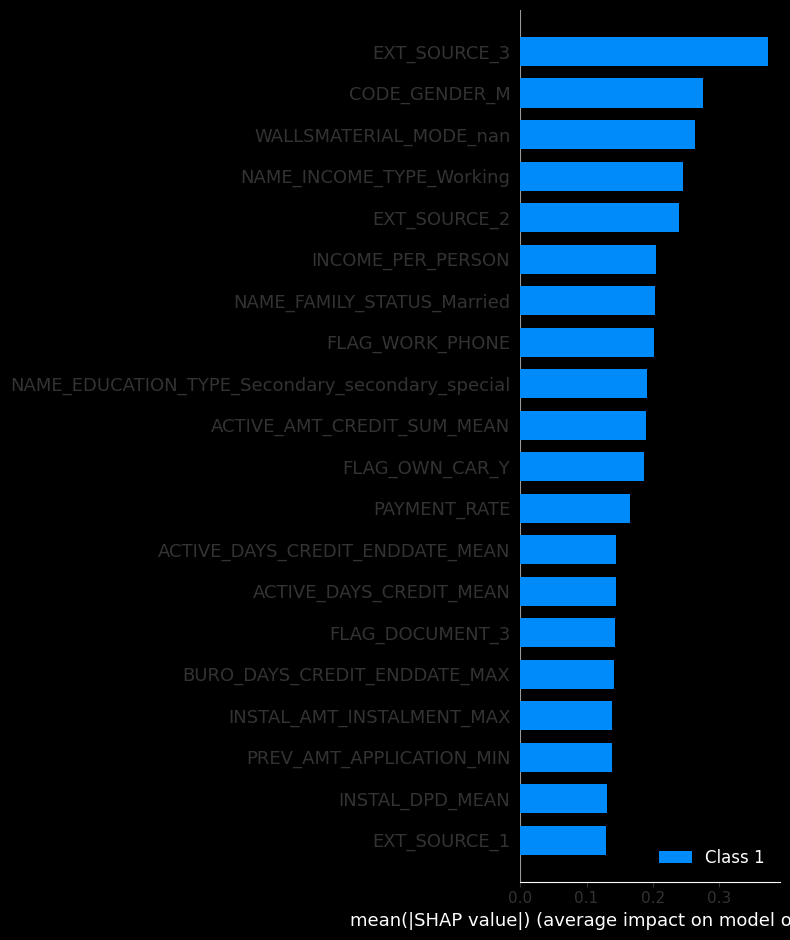

In [29]:
shap.summary_plot(shap_values, features=X, class_inds=[1])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


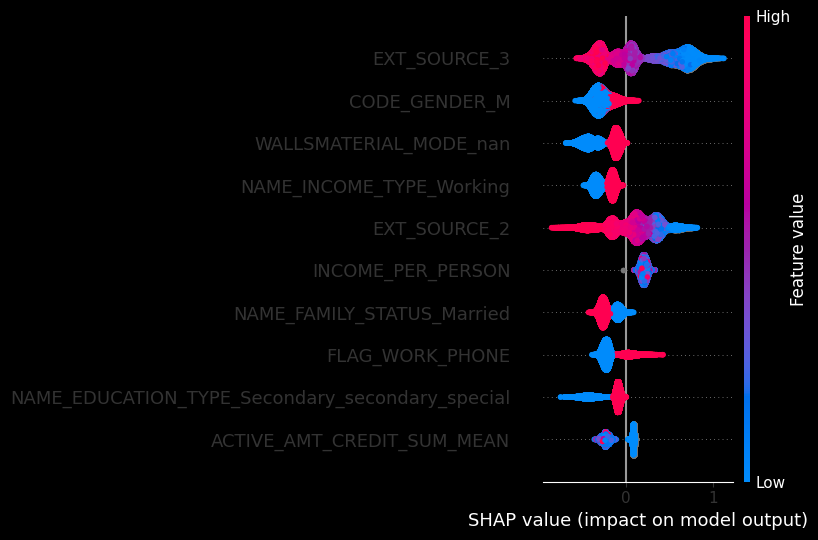

In [30]:
shap.summary_plot(shap_values[1], features=X, max_display=10)

In [32]:
explainer = shap.Explainer(clf, X[y > -1].to_numpy())  # X_train
shap_values = explainer(X[y > -1].to_numpy(), check_additivity=False)  # X_train
shap.plots.bar(shap_values)

AttributeError: 'TreeEnsemble' object has no attribute 'values'

# Choix du meilleur mod√®le

Nous avons pr√©-√©valu√© 3 types de mod√®les, r√©gression logistique, for√™t al√©atoire et LightGBM, sur la base d'un petit √©chantillon.

Il s'agit √† pr√©sent de passer √† l'√©chelle, avec d'une part un √©chantillon plus important, et une recherche en grille des meilleures configurations.

Il ne s'agit pas seulement de faire jouer les hyper-param√®tres de la LGBM, qui est la meilleure candidate pour la haute performance, mais de jouer √©galement sur les param√®tres li√©s √† la pr√©paration des donn√©es, l'√©chantillonnage √©quilibr√© et la mise √† l'√©chelle des donn√©es.

Nous n'utiliserons pas la pipeline de SKL, √©tant donn√© que notre fonction `kfold_train_and_eval_model` en est d√©j√† une.

Une recherche en grille va nous permettre de d√©terminer la meilleure configuration.

# S√©rialisation du meilleur mod√®le

C'est la derni√®re √©tape avant de passer √† la mise en production du mod√®le.

Quelle sont les m√©thodes ?

pickle, etc.

SKL en parle : pickle, le mod√®le de s√©rialsiation natif de Python n'est pas id√©al.

Voir la section [**Model persistence** (9)](https://scikit-learn.org/stable/model_persistence.html) du manuel d'utilisation.

avantages et inconv√©nients de chacune d'entre elles ?

Cette section est largement inspir√©e de la documentation d'utilisation de Scikit-learn.

In [28]:
import os
from pepper.env import get_tmp_dir

tmp_dir = get_tmp_dir()
clf_name = "lgbm_model_baseline"
model_pkl_path = os.path.join(tmp_dir, f"{clf_name}.pkl")

## Pickle et Jolib

Il est possible de sauvegarder un mod√®le dans scikit-learn en utilisant le mod√®le de persistance int√©gr√© de Python, √† savoir [pickle](https://docs.python.org/3/library/pickle.html)¬†:

In [ ]:
import pickle

with open(model_pkl_path, "wb") as f:
    pickle.dump(clf, f)

In [ ]:
import pickle

with open(model_pkl_path, "rb") as f:
    clf2 = pickle.load(f)

y_pred = clf2.predict(X[0:1])
y_true = y[0]

Dans le cas sp√©cifique de scikit-learn, il peut √™tre pr√©f√©rable de subtituer les `dump` & `load` de `joblib` √† ceux de `pickle`. `joblib` est plus efficace sur les objets qui comportent de grands tableaux `numpy` en interne, comme c'est souvent le cas pour les estimateurs ajust√©s de scikit-learn. Inconv√©nient : il n'est pas possible de *pickler* sur une cha√Æne, mais seulement de charger depuis le disque

In [ ]:
from joblib import dump, load

model_joblib_path = os.path.join(tmp_dir, f"{clf_name}.joblib")

dump(clf, model_joblib_path)

Le mod√®le pickl√© peut √™tre recharg√© plus tard (√©ventuellement dans un autre processus Python) avec¬†:

In [ ]:
dump(clf, model_joblib_path)

**NB** - les fonctions `dump` et `load` acceptent √©galement les objets de type fichier au lieu de noms de fichiers. 

Plus d'informations sur la persistance des donn√©es avec [**Joblib**](https://joblib.readthedocs.io/en/latest/persistence.html).

### Limites de s√©curit√© et de maintenabilit√©

pickle (et joblib par extension), a quelques probl√®mes concernant la maintenabilit√© et la s√©curit√©. √Ä cause de cela,
* Ne jamais charger de donn√©es non fiables, car cela pourrait entra√Æner l'ex√©cution d'un code malveillant lors du chargement.
* Bien que les mod√®les enregistr√©s √† l'aide d'une version de scikit-learn puissent se charger dans d'autres versions, cela n'est absolument pas pris en charge et d√©conseill√©. Il convient √©galement de garder √† l'esprit que les op√©rations effectu√©es sur ces donn√©es pourraient donner des r√©sultats diff√©rents et inattendus.

Afin de reconstruire un mod√®le similaire avec les futures versions de scikit-learn, des m√©tadonn√©es suppl√©mentaires doivent √™tre enregistr√©es avec le mod√®le pickl√©¬†:
* Les **donn√©es d'entra√Ænement**, par ex. une r√©f√©rence √† un instantan√© immuable
* Le **code source Python utilis√© pour g√©n√©rer le mod√®le**
* Les **versions de scikit-learn et ses d√©pendances**
* Le **score de validation crois√©e obtenu sur les donn√©es d'apprentissage**

Cela devrait permettre de v√©rifier que le score de validation crois√©e est dans la m√™me fourchette qu'auparavant.

√Ä quelques exceptions pr√®s, les mod√®les pickl√©s devraient √™tre portables sur toutes les architectures en supposant que les m√™mes versions de d√©pendances et de Python sont utilis√©es. Si vous rencontrez un estimateur qui n'est pas portable, veuillez ouvrir un probl√®me sur GitHub. Les mod√®les pickl√©s sont souvent d√©ploy√©s en production √† l'aide de conteneurs, comme Docker, afin de figer l'environnement et les d√©pendances.

Si vous souhaitez en savoir plus sur ces probl√®mes et explorer d'autres m√©thodes de s√©rialisation possibles, veuillez vous reporter √† cette [conf√©rence d'Alex Gaynor](https://pyvideo.org/pycon-us-2014/pickles-are-for-delis-not-software.html).

### Un format plus s√©curis√© : `skops`

[**`skops`**](https://skops.readthedocs.io/en/stable/) fournit un format plus s√©curis√© via le module [**`skops.io`**](https://skops.readthedocs.io/en/stable/modules/classes.html#module-skops.io). Il √©vite d'utiliser `pickle` et ne charge que des fichiers ayant des types et des r√©f√©rences √† des fonctions qui sont consid√©r√©s comme fiables par d√©faut ou par l'utilisateur. L'API est tr√®s similaire √† `pickle`, et vous pouvez persister vos mod√®les comme expliqu√© dans la [documentation](https://skops.readthedocs.io/en/stable/persistence.html) en utilisant [`skops.io.dump`](https://skops.readthedocs.io/en/stable/modules/classes.html#skops.io.dump) et [`skops.io.dumps`](https://skops.readthedocs.io/en/stable/modules/classes.html#skops.io.dump).

In [ ]:
import skops.io as sio
obj = sio.dumps(clf)

Les mod√®les peuvent √™tre recharg√©s en utilisant [`skops.io.load`](https://skops.readthedocs.io/en/stable/modules/classes.html#skops.io.load) et [`skops.io.loads`](https://skops.readthedocs.io/en/stable/modules/classes.html#skops.io.loads). Il faut n√©anmoins sp√©cifier les types de donn√©es consid√©r√©s fiables. Les types inconnus existants dans un objet / fichier dump√© peuvent √™tre pass√©s en revue √† l'aide de [`skops.io.get_untrusted_types`](https://skops.readthedocs.io/en/stable/modules/classes.html#skops.io.get_untrusted_types), et apr√®s cette v√©rification, l'objet peut √™tre pass√© √† la fonction de chargement.

In [ ]:
unknown_types = sio.get_untrusted_types(obj)
clf = sio.loads(obj, trusted=unknown_types)

Si vous faites confiance √† la source du fichier / objet, vous pouvez passer `trusted=True`.

In [ ]:
clf = sio.loads(obj, trusted=True)

## Formats interop√©rables : [sklearn-onnx](http://onnx.ai/sklearn-onnx/)

Pour des besoins de reproductibilit√© et de contr√¥le de la qualit√©, lorsque diff√©rentes architectures et environnements doivent √™tre pris en compte, l'exportation du mod√®le au format [Open Neural Network Exchange (ONNX)](https://onnx.ai/) ou au format [Predictive Model Markup Language (PMML)](https://dmg.org/pmml/v4-4-1/GeneralStructure.html) peut √™tre une meilleure approche que l'utilisation de pickle seul. Celles-ci sont utiles lorsque vous souhaitez utiliser votre mod√®le pour la pr√©diction dans un environnement diff√©rent de celui dans lequel le mod√®le a √©t√© form√©.

ONNX est une s√©rialisation binaire du mod√®le. Il a √©t√© d√©velopp√© pour am√©liorer l'utilisabilit√© de la repr√©sentation interop√©rable des mod√®les de donn√©es. Il vise √† faciliter la conversion des mod√®les de donn√©es entre diff√©rents frameworks d'apprentissage automatique, et √† am√©liorer leur portabilit√© sur diff√©rentes architectures informatiques. Plus de d√©tails sont disponibles dans le [tutoriel ONNX](https://onnx.ai/get-started.html). Pour convertir le mod√®le scikit-learn en ONNX, un outil sp√©cifique [sklearn-onnx](http://onnx.ai/sklearn-onnx/) a √©t√© d√©velopp√©.

PMML est une impl√©mentation de la norme de document [XML](https://en.wikipedia.org/wiki/XML) d√©finie pour repr√©senter des mod√®les de donn√©es avec les donn√©es utilis√©es pour les g√©n√©rer. √âtant lisible par l'homme et la machine, PMML est une bonne option pour la validation de mod√®les sur diff√©rentes plates-formes et l'archivage √† long terme. D'autre part, comme XML en g√©n√©ral, sa verbosit√© n'aide pas en production lorsque les performances sont critiques. Pour convertir le mod√®le scikit-learn en PMML, vous pouvez utiliser par exemple [sklearn2pmml](https://github.com/jpmml/sklearn2pmml) distribu√© sous la licence Affero GPLv3.

### Exemple SKL-ONNX

Extrait de http://onnx.ai/sklearn-onnx/

```Python
# Train a model.
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
iris = load_iris()
X, y = iris.data, iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y)
clr = RandomForestClassifier()
clr.fit(X_train, y_train)

# Convert into ONNX format
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
initial_type = [('float_input', FloatTensorType([None, 4]))]
onx = convert_sklearn(clr, initial_types=initial_type)
with open("rf_iris.onnx", "wb") as f:
    f.write(onx.SerializeToString())

# Compute the prediction with ONNX Runtime
import onnxruntime as rt
import numpy
sess = rt.InferenceSession("rf_iris.onnx", providers=["CPUExecutionProvider"])
input_name = sess.get_inputs()[0].name
label_name = sess.get_outputs()[0].name
pred_onx = sess.run([label_name], {input_name: X_test.astype(numpy.float32)})[0]
```